In [1]:
import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    import mplleaflet
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/GIS')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

import config
from set_rc import *

import pandas as pd
import shapefile as sf #in case you dont have it, form anaconda prompt: pip install pyshp
from flopy.utils.gridgen import Gridgen
from flopy.utils.reference import SpatialReference
from  pyproj import Proj

p = Proj("epsg:26910")
xll=595855
yll = 4059438
rotation = -13.5

flopy is installed in /home/users/ianpg/miniconda3/envs/SWIlarge-environment/lib/python3.8/site-packages/flopy
system: linux


In [2]:

#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#Create new MC_file
def create_MC_file():
    import datetime
    ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    MC_dir = Path(os.path.join(m.model_ws, 'MC_expt_' + ts))
    if not MC_dir.exists():
        MC_dir.mkdir()
    m.MC_file = MC_dir.joinpath('expt.txt')
    with m.MC_file.open('w') as wf:
        wf.close
    print(m.MC_file)
    return

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

#make a line across the grid
def get_line(start, end,allrows=1,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end

    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1

    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows==1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


#make all cells=0 above the line from get_line()
#Calculate freshwater head based on column of saltwater above each node (rho*g*z)
def shade_above(nlay,nrow,ncol,point_list,third_dim=1):
    import numpy as np
    grd = np.ones((nlay,nrow,ncol),dtype='int')
    ocean_hf = []
    if len(point_list)==0:
        return grd,ocean_hf
    for (lay,row,col) in point_list:
        grd[lay,:,col] = -1 #assign ocean ibound to -1
        grd[:lay,:,col] = 0 #assign cells above ocean to 0
        hf = densefresh/densesalt*ocean_elev - (densesalt - densefresh)/densefresh*(henry_botm[lay] +.5*delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay),int(irow),int(col),hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd,ocean_hf

def get_ocean_right_edge(m,ocean_line_tuple,startlay=None,col=None):
    import numpy as np
    point_list = []
    if col is None:
        col = m.ncol-1
    #If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple)==0:
        if startlay is None:
            startlay = 0
    elif max(ocean_line_tuple[0])==m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0])<m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay,m.nlay):
        for row in range(m.nrow):
            point_list.append((lay,row,col))
    point_list = tuple(np.array(point_list).T)
    return point_list

def add_pumping_wells(wel_data,ssm_data,n_wells,flx,rowcol,kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    wel_cells = []
    for k in range(n_wells):
        row,col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]*delv_weight[j]])
                    wel_cells.append((j,row,col))
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
            else:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,0])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
                    wel_cells.append((j,row,col))
                continue
    wel_cells = tuple(np.array(list(set(wel_cells))).T)
    return new_weldata, new_ssmdata,wel_cells

#Add recharge if desired
def make_rech_array(low=1e-2,high=1e0):
    import scipy.stats as sts
    llow,lhigh = np.log10((low,high))
    rech = np.exp(sts.uniform.rvs(size=1,loc=llow,scale=lhigh-llow)[0])
    return rech/(nrow*ncol)

def add_recharge_cells(recharge_generator,const=1,*args):
    if const==1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data

def sample_dist(distclass,size,*args):
    smp = distclass.rvs(*args,size=size)
    if size==1:
        smp=smp[-1]
    return smp

def write_sample(fname,varname,distclass,sample):
    fout= open(fname,"a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return

def truncate_grf(grid,lith_props,hk_vals,log10trans=True,plotyn=False,saveyn=False):
    grid_cutoffs = []
    for q in np.cumsum(lith_props):
        grid_cutoffs.append(np.quantile(grid,q))

    if plotyn:
        h = plt.hist(grid.flatten())
        for cutoff in grid_cutoffs:
            plt.vlines(cutoff,0,14000)
        plt.show()

    outgrid = np.ones(grid.shape,dtype=np.float32)
    for i,cutoff in reversed(list(enumerate(grid_cutoffs))):
        outgrid[np.where(grid<cutoff)] = hk_vals[i]

    if plotyn:
        f,axs = plt.subplots(2,1,sharex=True)
        axs[0].imshow(grid[:,0,:])
        axs[1].imshow(outgrid[:,0,:])
        if saveyn:
            plt.savefig(m.MC_file.parent.joinpath('Truncated_GRF.png').as_posix(),resolution=300)
    if log10trans:
        return np.power(10,outgrid)
    else:
        return outgrid

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))

def pec_num(delv,delc,delr,al):
    delL = (delv,delc,delr) #length in the lay,row,col directions
    pec_num = [round(d/al,2) for d in delL]
    for num,point  in zip(pec_num,('lay','row','col')):
        print('Pe = {} in the {} direction'.format(num,point))
    return pec_num

#%%

In [3]:
%%time
m_nm= flopy.modflow.Modflow.load('nm_cali.nam',version='mf2k',verbose=False,check=False,model_ws=nmgwmdir_cal.as_posix())
# m = flopy.modflow.Modflow.load(nmgwmdir_uncal.joinpath('C1-12_copy.nam').as_posix(),version='mf2k',verbose=False,check=False,model_ws=outputdir.joinpath('C1').as_posix())
m_nm.exe_name = config.mf2000exe
if not m_nm.DIS.lenuni==2:
    m_nm.DIS.delr *= .3048
    m_nm.DIS.delc *= .3048
    m_nm.DIS.top *= .3048
    m_nm.DIS.botm *= .3048
m_nm.DIS.lenuni = 2
m_nm.DIS.itmuni=4
m_nm.DIS.rotation=-13.5
# m_nm.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_nm.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_nm.DIS.proj4_str = p.srs
m_nm.modelgrid.set_coord_info(xoff=xll, yoff=yll, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')


CPU times: user 1min 7s, sys: 303 ms, total: 1min 7s
Wall time: 1min 7s


In [4]:
start_nm_yr = 1979
start_nm_mo = 10
start_nm_str = 'Oct 1979'
end_nm_yr = 2011
end_nm_mo = 9
end_nm_str = 'Sep 2011'
Lt_nm = ( (end_nm_yr + end_nm_mo/12)  - (start_nm_yr + start_nm_mo/12) )     *365
start_nm_datetime='{}/1/{}'.format(start_nm_mo,start_nm_yr)



start_m_yr = 1990
start_m_mo = 3
start_m_str = 'Mar 1990'

end_m_yr = 2030
end_m_mo = 10
end_m_str = 'Sep 2030'
Lt_m = ( (end_m_yr + end_m_mo/12)  - (start_m_yr + start_m_mo/12) )     *365
start_m_datetime='{}/1/{}'.format(start_m_mo,start_m_yr)






In [5]:
#Name model
modelname = 'NM'
model_ws = workdir.joinpath("NM_xsection")
#Name model
sw_exe = config.swexe #set the exe path for seawat

#Model discretization
Lz = 150.

nrow,ncol,nlay,nper = m_nm.nrow_ncol_nlay_nper

# rows = np.arange(100,102)
# rows = np.arange(100,102)
# rows = np.arange(m_nm.nrow-102,   m_nm.nrow-101) #NM super reduced

# rows = np.arange(nrow)
# rows = np.arange(m_nm.nrow-159,   m_nm.nrow-132) #SV
# rows = np.arange(m_nm.nrow-114,   m_nm.nrow-74) #NM
# rows = np.arange(m_nm.nrow-114,   m_nm.nrow-113) #NM reduced, tsw included in domain

# rows= np.arange(196,197)
# rows= np.arange(197,198)

rows= np.arange(142,143)

cols = np.arange(ncol)
nrow =len(rows) 
ncol = len(cols)
nlay=20


henry_top = 2
ocean_elev = 0
delv_first = 4
botm_first = henry_top-delv_first


delv = (Lz-delv_first) / (nlay-1)
delr = m_nm.dis.delr.array[0]
delc = m_nm.dis.delc.array[0]

henry_botm = np.hstack(([botm_first],np.linspace(botm_first-delv,henry_top-Lz,nlay-1)))
delv_vec = np.hstack((delv_first,np.repeat(delv,nlay-1)))
delv_weight = [x/np.sum(delv_vec) for x in delv_vec]


topo_grid = np.load(GISdir.joinpath('topo_grid.npy'))
henry_top = topo_grid[(slice(rows[0],rows[-1]+1),slice(cols[0],cols[-1]+1))]


# beachslope = .05
# ocean_col = [np.floor(ncol-1).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn
# ocean_col = [np.floor(ncol/2).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn

# inland_elev = beachslope*ocean_col[0]*delr
# offshore_elev = -beachslope*(ocean_col[1]-ocean_col[0])*delr


#Period data
# nyrs= 2
# Lt = 365*nyrs #Length of time in days

perlen = list(np.repeat(365/2,int(Lt_m/(365/2))))
nper = len(perlen)
nstp = np.ones_like(perlen,dtype=np.int)

# nstp = m_nm.dis.nstp.array
# perlen = m_nm.dis.perlen.array
# nper = m_nm.nper





steady = [False for x in range(len(perlen))] #Never steady
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1.1
ssm_data = None
verbose = True

print('Model setup: \n'
      'nlay: {}\n'
      'nrow: {}\n'
      'ncol: {}\n'
      'Total cells: {}\n'
      'Total time: {} days\n'
      'nper: {}\n'.format(nlay,nrow,ncol,nlay*nrow*ncol,Lt_m,nper))
# In[4]:

#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws.as_posix(),verbose=verbose)
# SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,
                               start_datetime=start_m_datetime)

xll=595855
yll = 4059438
rotation=-13.5
# p = Proj(proj='utm',zone='10n',ellps='WGS84',units='meters', preserve_units=False)

m.DIS.lenuni = 2
m.DIS.itmuni=4
m.DIS.rotation=-13.5
# m.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m.DIS.proj4_str = p.srs
xll_m,yll_m = m_nm.modelgrid.xvertices[rows[-1]+1,0],m_nm.modelgrid.yvertices[rows[-1]+1,0]


m.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')
print(m.modelgrid)


np.save(model_ws.joinpath('rows.npy'),rows)
np.save(model_ws.joinpath('starttime.npy'),start_m_yr + start_m_mo/12)

Model setup: 
nlay: 20
nrow: 1
ncol: 345
Total cells: 6900
Total time: 14812.916666666639 days
nper: 81

NM.nam
adding Package:  DIS
xll:598089.2472161239; yll:4068744.309415646; rotation:-13.5; proj4_str:+proj=utm +zone=10 +datum=NAD83 +units=m +no_defs; units:undefined; lenuni:0


In [6]:
m_empty = flopy.modflow.Modflow('m_empty', model_ws=model_ws.joinpath('m_empty').as_posix())

flopy.modflow.ModflowDis(m_empty, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult,start_datetime=start_m_datetime)

m_empty.DIS.lenuni = 2
m_empty.DIS.itmuni=4
m_empty.DIS.rotation=-13.5
# m_empty.DIS.xul = xll + 18288.0*np.sin(13.5*180/np.pi) #upper left UTM Zone 10N
# m_empty.DIS.yul = yll + 18288.0*np.cos(13.5*180/np.pi)  #upper left UTM Zone 10N
m_empty.DIS.proj4_str = p.srs
m_empty.modelgrid.set_coord_info(xoff=xll_m, yoff=yll_m, angrot=rotation, proj4=p.srs)#,epsg='nad83-utm-zone-10n')



In [7]:
gridgen_ws = model_ws.joinpath('gridgen')
if not gridgen_ws.exists():
    gridgen_ws.mkdir()
g = Gridgen(m_empty.dis, model_ws=gridgen_ws.as_posix(),exe_name=config.gridgenexe,surface_interpolation='replicate')
g.build(verbose=False)

In [8]:
f_swi_180 = GISdir.joinpath("chloride_contours",'SWI_180_lines_noz.shp').as_posix()
swi_180 = sf.Reader(f_swi_180)
yrs_180 = [ int(r[-1]) for r in swi_180.records()]


for yr in yrs_180:
    f_exp = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
    with sf.Writer(f_exp) as w:
        w.fields = swi_180.fields[1:] # skip first deletion field
        for feature in swi_180.iterShapeRecords(): # iteration on both record and shape for a feature
            if int(feature.record[-1])==yr:
                w.record(*feature.record) # * for unpacking tuple
                w.shape(feature.shape)

f_swi_400 = GISdir.joinpath("chloride_contours",'SWI_400_lines_noz.shp').as_posix()
swi_400 = sf.Reader(f_swi_400)
yrs_400 = [ int(r[-1]) for r in swi_400.records()]


for yr in yrs_400:
    f_exp = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
    with sf.Writer(f_exp) as w:
        w.fields = swi_400.fields[1:] # skip first deletion field
        for feature in swi_400.iterShapeRecords(): # iteration on both record and shape for a feature
            if int(feature.record[-1])==yr:
                w.record(*feature.record) # * for unpacking tuple
                w.shape(feature.shape)      
                
layer =3
yr = yrs_180[-1]
f_shp_180 = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
int_180 = g.intersect(f_shp_180,'polygon',layer=layer)
g.nodes = g.get_nodes()
a = np.zeros((g.nodes), dtype=np.int)
a[int_180.nodenumber] = 1
a180 = a.reshape((nlay,nrow,ncol),order='C')


yr = yrs_400[-1]
f_shp_400 = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
int_400 = g.intersect(f_shp_400,'polygon',layer=layer)
g.nodes = g.get_nodes()
a = np.zeros((g.nodes), dtype=np.int)
a[int_400.nodenumber] = 1
a400 = a.reshape((nlay,nrow,ncol),order='C')

def intersect_swi_contour(aquifer=180,yr_ind=None):
    if aquifer==180:
        yr = yrs_180[yr_ind]
        f = GISdir.joinpath("chloride_contours","by_year_180","swi_180_{}".format(yr)).as_posix()
    elif aquifer==400:
        yr = yrs_400[yr_ind]
        f = GISdir.joinpath("chloride_contours","by_year_400","swi_400_{}".format(yr)).as_posix()
    else:
        raise('enter either 180 or 400')
    int_obj = g.intersect(f,'polygon',layer=layer)
    a = np.zeros((g.nodes), dtype=np.int)
    a[int_obj.nodenumber] = 1
    return a.reshape((nlay,nrow,ncol),order='C')


from scipy.interpolate import interp2d,RectBivariateSpline,NearestNDInterpolator,griddata
def make_surf(grid_old,m_old,m_new,method='nearest'):
    points = np.stack((m_old.modelgrid.xcellcenters.flatten(),m_old.modelgrid.ycellcenters.flatten())).T
    values = grid_old.flatten()
    grid_x=  m_new.modelgrid.xcellcenters
    grid_y=  m_new.modelgrid.ycellcenters
    return griddata(points, values, (grid_x, grid_y), method=method)


In [9]:
botm_orig= m_nm.DIS.botm.array[:6]
layer_mapping = np.zeros((7,nlay,nrow,ncol),dtype=bool)
for lay in range(7):
    if lay==0:
        ind_inlay = np.zeros((nlay,nrow,ncol),dtype=np.bool)
        ind_inlay[0,:,:] = True
    elif lay==6:
#         botm_orig_lay = interp_surf2newgrid(botm_orig[lay-1])
        botm_orig_lay = make_surf(botm_orig[-1],m_nm,m_empty)
        ind_inlay = m_empty.dis.botm.array<botm_orig_lay
    else:
        botm_orig_lay = make_surf(botm_orig[lay],m_nm,m_empty)
        top_orig_lay = make_surf(botm_orig[lay-1],m_nm,m_empty)
        ind_inlay =np.logical_and(m_empty.dis.botm.array>=botm_orig_lay,m_empty.dis.botm.array<top_orig_lay)
    layer_mapping[lay,:,:,:] = ind_inlay
    
    
    
layer_mapping_ind = np.zeros((nlay,nrow,ncol),dtype=int)
for lay in range(7):
    if lay==0:
        val=-50
    if lay==6:
        val=50
    else:
        val=lay
    layer_mapping_ind+=layer_mapping[lay].astype(int)*val
    
layer_mapping_ind[layer_mapping_ind<=0]= 0
layer_mapping_ind[layer_mapping_ind>=6]=6


In [11]:
kj_lay.shape

(52, 300, 345)

In [13]:
kj_lay = np.load(GISdir.joinpath('KJ_boundaries','AEM_Modflowsize_KJboundaries.npy'))
kj_lay=kj_lay.reshape((52,m_nm.nrow,m_nm.ncol))[::-1,::-1,:]
ind_top_lay_0_lf = 20
ind_bot_lay_0_lf = 21
ind_bot_lay_19_lf = 40


rm_lay4 = np.where(layer_mapping_ind==4)
# rm_lay4 = (rm_lay4[0][rm_lay4[2]<=150],
#            rm_lay4[1][rm_lay4[2]<=150],
#            rm_lay4[2][rm_lay4[2]<=150] )
layer_mapping_ind_no4  = layer_mapping_ind.copy()
layer_mapping_ind_no4[np.where(layer_mapping_ind==4)] =3

kj_lay = kj_lay[ind_top_lay_0_lf:ind_bot_lay_19_lf,rows,:]   
kj_lay_red = np.zeros_like(kj_lay)
kj_lay_red[np.where(kj_lay==1)]=1
kj_lay_red[np.where(kj_lay==2)]=1
kj_lay_red[np.where(kj_lay==3)]=2  # SVA
kj_lay_red[np.where(kj_lay==4)]=3
kj_lay_red[np.where(kj_lay==5)]=2.5  #int 180
kj_lay_red[np.where(kj_lay==6)]=3
kj_lay_red[np.where(kj_lay==7)]=4  #180/400-FA
kj_lay_red[np.where(kj_lay==8)]=5
kj_lay_red[np.isnan(kj_lay)]=layer_mapping_ind_no4[np.isnan(kj_lay)]

# np.save(GISdir.joinpath('KJ_boundaries','kj_lay_red_full.npy'),kj_lay_red)

In [14]:
kj_lay = np.load(GISdir.joinpath('KJ_boundaries','AEM_Modflowsize_KJboundaries.npy'))
kj_lay=kj_lay.reshape((52,m_nm.nrow,m_nm.ncol))[::-1,::-1,:]
ind_top_lay_0_lf = 20
ind_bot_lay_0_lf = 21
ind_bot_lay_19_lf = 40


rm_lay4 = np.where(layer_mapping_ind==4)
# rm_lay4 = (rm_lay4[0][rm_lay4[2]<=150],
#            rm_lay4[1][rm_lay4[2]<=150],
#            rm_lay4[2][rm_lay4[2]<=150] )
layer_mapping_ind_no4  = layer_mapping_ind.copy()
layer_mapping_ind_no4[rm_lay4] =3




kj_lay = kj_lay[ind_top_lay_0_lf:ind_bot_lay_19_lf,rows,:]   
kj_lay_red = np.zeros_like(kj_lay)
kj_lay_red[np.where(kj_lay==1)]=1
kj_lay_red[np.where(kj_lay==2)]=1
kj_lay_red[np.where(kj_lay==3)]=2  # SVA
kj_lay_red[np.where(kj_lay==4)]=3
kj_lay_red[np.where(kj_lay==5)]=2.5  #int 180
kj_lay_red[np.where(kj_lay==6)]=3
kj_lay_red[np.where(kj_lay==7)]=4  #180/400-FA
kj_lay_red[np.where(kj_lay==8)]=5
kj_lay_red[np.isnan(kj_lay)]=layer_mapping_ind_no4[np.isnan(kj_lay)]



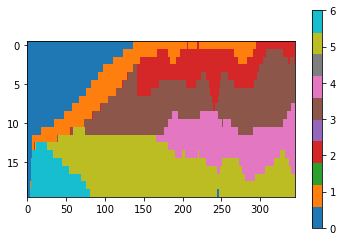

In [15]:
plt.imshow(kj_lay_red[:,-1,:],cmap='tab10',interpolation='nearest')
plt.gca().set_aspect(10)
plt.colorbar()

In [16]:
hk_nm = m_nm.lpf.hk.array
x_nm = m_nm.modelgrid.xcellcenters
y_nm = m_nm.modelgrid.ycellcenters
z_nm = m_nm.modelgrid.zcellcenters
x_m = m_empty.modelgrid.xcellcenters
y_m = m_empty.modelgrid.ycellcenters
z_m = m_empty.modelgrid.zcellcenters


hkSand = 1e2 #horizontal hydraulic conductivity m/day
hkClay = hkSand*.001

hk_new = griddata(points=(np.tile(x_nm,(m_nm.dis.nlay,1,1)).flatten(),np.tile(y_nm,(m_nm.dis.nlay,1,1)).flatten(),z_nm.flatten()),
               values=hk_nm.flatten(),
               xi=(x_m,y_m,z_m),method='nearest')


hk_new[np.isnan(hk_new)] = np.max(hk_new[np.logical_and(layer_mapping_ind==1,hk_new<10000)])
hk_new[hk_new>10000] = np.max(hk_new[np.logical_and(layer_mapping_ind==1,hk_new<10000)])



hk_new[layer_mapping_ind==4]=hkClay*.01

#Hydraulic conductivity field

# heterogenous = 0 #0:homogenous,1:variogram,2:MPS

# hk = np.ones((nlay,nrow,ncol), dtype=np.float)
# hk[np.isin(layer_mapping_ind,(0,1,3,5))] = hkSand
# hk[np.isin(layer_mapping_ind,(2,4,6))] = hkClay


hk = hk_new 
#plt.figure(),plt.imshow((hk[:,0,:])),plt.colorbar(),plt.title('Sill:{}'.format(sill)),plt.show()

#Set Hydraulic properties
sy = 0.15
ss = 1e-5
por = 0.3
vka = .5 # = vk/hk
al = 20 #longitudinal dispersivity (m) from Walther et al. 2017
dmcoef = 2e-9 #m2/day

#Variable density parameters
Csalt = 35.0001
Cfresh = .2
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)
#denseslp = 0 #trick for testing constant density

In [17]:
it=1
f_varlist = Path('../data/PriorModel/varlist.pkl')
job_id='test'

if len(f_varlist.name.split('.'))>1:
    nam = f_varlist.name.split('.')[0]
else:
    nam = f_varlist.name
varlist = load_obj(f_varlist.parent,nam)
ts = make_timestamp()

layer_mapping_ind_full = np.load(GISdir.joinpath('layer_mapping_ind_full.npy'))                                 
layer_mapping_ind = layer_mapping_ind_full[:,rows,:]


print('unpacking and setting vars...')




unpacking and setting vars...


In [18]:
##Unpack vars
por_sand = varlist['por_sand'][it] #done
por_clay = varlist['por_clay'][it] #done
aL = varlist['aL'][it] #done
kvh = varlist['kvh'][it] #done
kh_sand_180 = varlist['kh_sand_180'][it] #done
kh_clay_180 = varlist['kh_clay_180'][it] #done
kh_sand_400 = varlist['kh_sand_400'][it] #done
kh_clay_400 = varlist['kh_clay_400'][it] #done
kh_lay1     = varlist['kh_lay1'][it] #done 
DSA_head    = varlist['DSA_head'][it] #done 




#Changed vars
kh_sand_180 = 100
kh_clay_180 = .01
kh_sand_400 = 100
kh_clay_400 = .01


DSA_head = 8
aL=1

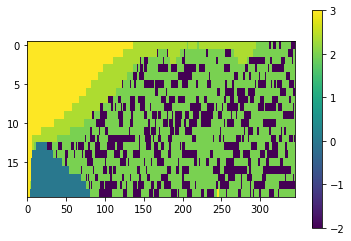

In [19]:
lithdir = datadir.joinpath('lith/sgems/')
hk = np.zeros_like(kj_lay_red,dtype=np.float)
ibound = np.ones((nlay,nrow,ncol),dtype=np.int)



hk_aquitard = min(kh_clay_180,kh_clay_400)

lith_180 = np.load(lithdir.joinpath('snesim','mps180_{}.npy'.format(it))).astype(np.float)[:,rows,:]
# lith_400 = np.load(lithdir.joinpath('sisim','sisim400_{}.npy'.format(it))).astype(np.float)[:,rows,:]
lith_400 = lith_180.copy()

lith_180[lith_180==1.] = kh_sand_180
lith_180[lith_180==0.] = kh_clay_180
lith_400[lith_400==1.] = kh_sand_180
lith_400[lith_400==0.] = kh_clay_400




hk[np.where(kj_lay_red==0)] = 10000
hk[np.where(kj_lay_red==1)] = kh_lay1
hk[np.where(kj_lay_red==2)] = lith_180[np.where(kj_lay_red==2)] #SVA
# hk[np.where(kj_lay_red==2)] = hk_aquitard
hk[np.where(kj_lay_red==2.5)] = lith_180[np.where(kj_lay_red==2.5)] #int 180
# hk[np.where(kj_lay_red==2.5)] = hk_aquitard

hk[np.where(kj_lay_red==3)] = lith_180[np.where(kj_lay_red==3)]
hk[np.where(kj_lay_red==4)] = lith_180[np.where(kj_lay_red==4)]
# hk[np.where(kj_lay_red==4)] = hk_aquitard
hk[np.where(kj_lay_red==5)] = lith_400[np.where(kj_lay_red==5)]
hk[np.where(kj_lay_red>5)] = 1.



prsity = np.zeros_like(kj_lay_red,dtype=np.float)
prsity[np.isin(hk,(kh_lay1,kh_sand_180,kh_sand_400))]=por_sand
prsity[np.where(prsity==0.)]=por_clay


# hk = hk[:,rows,:]
# prsity = prsity[:,rows,:]


plt.figure()
plt.imshow(np.log10(hk)[:,0,:],vmin=-2,vmax=3,interpolation='nearest')
plt.gca().set_aspect(10)
plt.colorbar()

In [176]:
def find_ocean(m,layer_mapping_ind):
    ocean_line = []

    for lay in range(m.dis.nlay):
        for row in range(m.dis.nrow):
            thislay = (lay,row,np.where(layer_mapping_ind[lay,row,:]!=0)[0][0])
            ocean_line.append(thislay)
            if lay==m.dis.nlay-1:
                pass
            else:
                nextlay = (lay+1,row,np.where(layer_mapping_ind[lay+1,row,:]!=0)[0][0])
                for col in np.arange(thislay[2],nextlay[2],-1):
                    ocean_line.append((lay,row,col))
    ocean_line = np.array(ocean_line).T


    ocean_grid = np.zeros((nlay,nrow,ncol),dtype=np.bool)
    ocean_grid[tuple(ocean_line)]=True
    ocean_grid[m.modelgrid.zvertices[1:,:,:]>ocean_elev]=False
    return ocean_line,ocean_grid

ocean_line,ocean_grid = find_ocean(m,layer_mapping_ind)


itype = flopy.mt3d.Mt3dSsm.itype_dict()
cond = 1000.

ghb_data_ocean = {}
ssm_data_ocean = {}
for kper in range(nper):
    if kper%50==0:
        print('kper',kper)
    ghb_per = []
    ssm_per = []
    #Ocean boundary
    for v in np.argwhere(ocean_grid):
        ghb_per.append([v[0],
                       v[1],
                       v[2],
                       #ocean_hf[3][j],
                        ocean_elev,
                       cond])
        #SSM: {stress_period: [lay,row,col,concentration,itype]}
        ssm_per.append([v[0],
                       v[1],
                       v[2],
                       Csalt,
                       itype['GHB']])
    ghb_data_ocean[kper]=ghb_per
    ssm_data_ocean[kper]=ssm_per
    
# print(np.where(ibound[tuple(np.array(ghb_data_ocean[0])[:,:3].astype(int).T)]==0))

inds = []
nix_ghb = []
for v in ocean_line.T:
# v = ocean_line.T[-1]
    if 6 in layer_mapping_ind[v[0],v[1],v[2]:v[2]+10]:
        inds.append((v[0],v[1],int(np.argwhere(layer_mapping_ind[v[0],v[1],v[2]:v[2]+10]==6)[0]) + v[2]))
        nix_ghb.append(v)

        
for kper in range(nper):
    for v in nix_ghb:
        try:
            ghb_data_ocean[kper].remove([v[0],v[1],v[2],0,cond])
            ssm_data_ocean[kper].remove([v[0],v[1],v[2],Csalt,itype['GHB']])
        except:
            continue

kper 0
kper 50


In [177]:
bhead_mean_180=  []
bhead_mean_400 = []
bhead_180400 = []

for per in range(m_nm.nper):
    msk = np.logical_and(m_nm.ghb.stress_period_data[per]['j']==344,
                     m_nm.ghb.stress_period_data[per]['k']==3)
    bhead_mean_180.append(m_nm.ghb.stress_period_data[per][msk]['bhead'].mean())
    
    msk = np.logical_and(m_nm.ghb.stress_period_data[per]['j']==344,
                     m_nm.ghb.stress_period_data[per]['k']==5)
    bhead_mean_400.append(m_nm.ghb.stress_period_data[per][msk]['bhead'].mean())
    
    msk = np.logical_and(m_nm.ghb.stress_period_data[per]['j']==344,
                     m_nm.ghb.stress_period_data[per]['k']==4)
    bhead_180400.append(m_nm.ghb.stress_period_data[per][msk]['bhead'].mean())
    
    
    
    
yr = np.arange(2012,2019)
dlvl_180 = np.array([-2,-1,-8,-7,0,11,.5,2])*.3048
dlvl_400 = np.array([-1,-1,-7,-4,1,8,-.5,2])*.3048

bhead_future_180 = [np.array(bhead_mean_180)[-12:]+dlvl for dlvl in dlvl_180]
bhead_future_180 = np.array(bhead_future_180).flatten()
bhead_future_180 = np.r_[bhead_future_180,np.tile(bhead_future_180[-12:],20)]
bhead_future_180 = bhead_future_180[5::6]

bhead_future_400 = [np.array(bhead_mean_400)[-12:]+dlvl for dlvl in dlvl_400]
bhead_future_400 = np.array(bhead_future_400).flatten()
bhead_future_400 = np.r_[bhead_future_400,np.tile(bhead_future_400[-12:],20)]
bhead_future_400 = bhead_future_400[5::6]


inland_inds_180 = np.argwhere(layer_mapping_ind==3)
inland_inds_180 = inland_inds_180[inland_inds_180[:,2]==344,:]

inland_inds_180400 = np.argwhere(layer_mapping_ind==4)
inland_inds_180400 = inland_inds_180400[inland_inds_180400[:,2]==344,:]

inland_inds_400 = np.argwhere(layer_mapping_ind==5)
inland_inds_400 = inland_inds_400[inland_inds_400[:,2]==344,:]



In [178]:
z_m_vert = m_empty.modelgrid.zvertices
ghb_data_nm = m_nm.ghb.stress_period_data.data

def date_from_per(kper_m):
    return  (start_m_yr + start_m_mo/12) + np.sum(perlen[:kper_m])/365


bheads180 = []
bheads400 = []
dates = []
for kper_nm in range(m_nm.nper):
    ghb_per=[]
    ssm_per = []


    lay=3
    msk = np.logical_and(np.logical_and(np.isin(ghb_data_nm[kper_nm]['i'],rows),
                                                    ghb_data_nm[kper_nm]['j']==344)
                                     ,ghb_data_nm[kper_nm]['k']==lay)
    bheads180.append(ghb_data_nm[kper_nm][msk]['bhead'].mean())

    lay=5
    msk = np.logical_and(np.logical_and(np.isin(ghb_data_nm[kper_nm]['i'],rows),
                                                    ghb_data_nm[kper_nm]['j']==344)
                                     ,ghb_data_nm[kper_nm]['k']==lay)
    bheads400.append(ghb_data_nm[kper_nm][msk]['bhead'].mean())
    dates.append((start_nm_yr + start_nm_mo/12) + kper_nm/12)
    
    
bhead_future_180 = np.array([np.array(bheads180)[-12:]+dlvl for dlvl in dlvl_180]).flatten()
bhead_future_180 = np.r_[bhead_future_180,np.tile(bhead_future_180[-12:],20)]

bhead_future_400 = np.array([np.array(bheads400)[-12:]+dlvl for dlvl in dlvl_400]).flatten()
bhead_future_400 = np.r_[bhead_future_400,np.tile(bhead_future_400[-12:],20)]

dates_future = dates[-1] + np.linspace(1/12,1/12*len(bhead_future_180),len(bhead_future_180))


bheads180 = np.r_[bheads180,bhead_future_180]
bheads400 = np.r_[bheads400,bhead_future_400]
dates  = np.r_[dates,dates_future]


    
    
###Smooth and sample
    
from scipy.interpolate import interp1d

def conv_signal(x,N=2):
    bheads_conv = np.convolve(x, np.ones((N,))/N, mode='valid')
    if N%2==0:
        return np.r_[np.ones(int(np.floor((N-1)/2)))*bheads_conv[0],
                            bheads_conv,
                            np.ones(int(np.ceil((N-1)/2)))*bheads_conv[-1] ]
    else:
        return np.r_[np.ones(int((N-1)/2))*bheads_conv[0],
                     bheads_conv,
                     np.ones(int((N-1)/2))*bheads_conv[-1]]
    
    
dates_m = np.array([date_from_per(kper) for kper in range(m.nper)])
interpolator = interp1d(dates,conv_signal(bheads400,12),kind='cubic')

bheads180_interp = interp1d(dates,conv_signal(bheads180,12),kind='cubic')(dates_m)
bheads400_interp = interp1d(dates,conv_signal(bheads400,12),kind='cubic')(dates_m)


plt.plot(dates_m,bheads180_interp)
plt.plot(dates_m,bheads400_interp)
    
    
ghb_data_inland = {}
ssm_data_inland = {}
#Assign
for per in range(m.nper):
    ghb_per=[]
    ssm_per = []
    if per%10==0:
        print('kper_m {}, date {}'.format(per,dates_m[per]))
            
    for ind in inland_inds_180:
        k,i,j = ind
        bhead =bheads180_interp[per]
        if bhead < z_m_vert[k+1,i,j]:
            print(k,i,j,bhead - z_m_vert[k+1,i,j])
        else:
            ghb_per.append((k,i,j,bhead,cond))
            ssm_per.append([k,i,j,Cfresh,itype['GHB']])

    for ind in inland_inds_180400: #Same bhead as 180-FA
        k,i,j = ind
        bhead =bheads180_interp[per]
        if bhead < z_m_vert[k+1,i,j]:
            print(k,i,j,bhead - z_m_vert[k+1,i,j])
        else:
            ghb_per.append((k,i,j,bhead,cond))
            ssm_per.append([k,i,j,Cfresh,itype['GHB']])

    for ind in inland_inds_400:
        k,i,j = ind
        bhead =bheads400_interp[per]
        if bhead < z_m_vert[k+1,i,j]:
            print(k,i,j,bhead - z_m_vert[k+1,i,j])
        else:
            ghb_per.append((k,i,j,bhead,cond))
            ssm_per.append([k,i,j,Cfresh,itype['GHB']])
        
    ghb_data_inland[per]=ghb_per
    ssm_data_inland[per]=ssm_per  

kper_m 0, date 1990.25
3 0 344 -3.2098687489827533
3 0 344 -5.618202050526936
3 0 344 -6.39736874898275
3 0 344 -6.483201980590813
3 0 344 -7.339035352071136
3 0 344 -5.270701885223389
3 0 344 -1.2082018852233958
kper_m 10, date 1995.25
kper_m 20, date 2000.25
kper_m 30, date 2005.25
kper_m 40, date 2010.25
kper_m 50, date 2015.25
kper_m 60, date 2020.25
kper_m 70, date 2025.25
kper_m 80, date 2030.25


##### RCH

date: 1990.25; kper_m 0
date: 1995.25; kper_m 10
date: 2000.25; kper_m 20
date: 2005.25; kper_m 30
date: 2010.25; kper_m 40
date: 2015.25; kper_m 50
date: 2020.25; kper_m 60
date: 2025.25; kper_m 70
date: 2030.25; kper_m 80
kper 0
kper 50


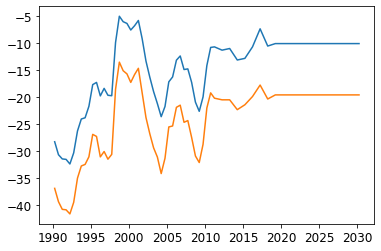

In [179]:
layer =1
f_exp = GISdir.joinpath("sva_edge_2","SVA_edge").as_posix()
int_sva = g.intersect(f_exp,'line',layer=layer)
g.nodes = g.get_nodes()
a = np.zeros((g.nodes), dtype=np.int)
a[int_sva.nodenumber] = 1
asva = a.reshape((nlay,nrow,ncol),order='C')

asva_inds = np.argwhere(asva)
# asva_inds_adj = asva_inds.copy()
# asva_inds_adj[:,2]=asva_inds_adj[:,2]-1
# asva_inds = np.r_[asva_inds,asva_inds_adj]
ibound[tuple(asva_inds.T)] = 1

bhead  = .1
chd_data =  {}
ssm_rech = {}
for kper_m in range(nper):
    chd_per=[]
    ssm_per = []
    if kper_m%10==0:
        print('date: {}; kper_m {}'.format(
            date_from_per(kper_m),kper_m))
    
    for ind in asva_inds:
        k,i,j = ind
        chd_per.append([k,i,j-1,bhead,bhead]) #[lay, row, col, shead, ehead]
        ssm_per.append([k,i,j-1,Cfresh,itype['CHD']])
    
    chd_data[kper_m] = chd_per
    ssm_rech[kper_m] = ssm_per
    
    
ghb_data = {}
ssm_data = {}
for kper in range(nper):
    if kper%50==0:
        print('kper',kper)
    ghb_per = ghb_data_ocean[kper]
    ssm_per = ssm_data_ocean[kper]
    for vg,vs in zip(ghb_data_inland[kper],ssm_data_inland[kper]):
        ghb_per.append(vg)
        ssm_per.append(vs)
    
    #Add recharge data if coded as CHD/GHB/etc.. data
    for vc in ssm_rech[kper]:
        ssm_per.append(vc)
    
#     for vg in ghb_data_rech[kper]:
#         ghb_per.append(vg)
    
    ghb_data[kper] = ghb_per
    ssm_data[kper] = ssm_per

### SCONC

In [180]:
yr_ind = np.argmin(np.abs([v - (start_m_yr + start_m_mo/12) for v in yrs_180]))
yr_ind=1
a_180 = intersect_swi_contour(aquifer=180,yr_ind=yr_ind)
nonzerolay = int(np.argwhere([v.any() for v in a_180]))
a_180 = np.tile(a_180[nonzerolay],(nlay,1,1))


yr_ind = np.argmin(np.abs([v - (start_m_yr + start_m_mo/12) for v in yrs_400]))
yr_ind=0

a_400 = intersect_swi_contour(aquifer=400,yr_ind=yr_ind)
nonzerolay = int(np.argwhere([v.any() for v in a_400]))
a_400 = np.tile(a_400[nonzerolay],(nlay,1,1))
salt_180 =np.logical_and(a_180==1,layer_mapping_ind==3)
salt_400 =np.logical_and(a_400==1,layer_mapping_ind==5)


salt_180 =np.logical_and(a_180==1,layer_mapping_ind==3)
for lay in range(nlay):
    for row in range(nrow):
        inds_nonzero = np.argwhere(salt_180[lay,row,:])
        if len(inds_nonzero)>0:
            salt_180[lay,row,:int(inds_nonzero[0])]=True
            
salt_400 =np.logical_and(a_400==1,layer_mapping_ind==5)
for lay in range(nlay):
    for row in range(nrow):
        inds_nonzero = np.argwhere(salt_400[lay,row,:])
        if len(inds_nonzero)>0:
            salt_400[lay,row,:int(inds_nonzero[0])]=True


In [181]:
ind_ocean = np.where(ocean_grid[1,0,:])[0].max()
# ocean_lay = np.where((layer_mapping_ind[:,row,:]==3).any(axis=1))[0].min() # highest layer within the 180-FA containing the ocean
# ind_ocean = np.where(ocean_grid[ocean_lay,0,:])[0].max() #farthest inland point for the given row corresponding to the ocean



saltgrad_180 = np.zeros_like(a_180)
for lay in range(nlay):
    for row in range(nrow):
        ind_max = np.argwhere(a_180[lay,row,:])
        if len(ind_max)>0:
#             ind_ocean = np.argwhere(ocean_grid[lay,row,:]).max()
            tds_vec = np.linspace(Csalt,250/1000, ind_max.max()-ind_ocean)
            saltgrad_180[lay,row,:ind_ocean]=Csalt
            saltgrad_180[lay,row,ind_ocean:ind_max.max()]=tds_vec
            

saltgrad_400 = np.zeros_like(a_400)
for lay in range(nlay):
    for row in range(nrow):
        ind_max = np.argwhere(a_400[lay,row,:])
        if len(ind_max)>0:
#             ind_ocean = np.argwhere(ocean_grid[lay,row,:]).max()
            tds_vec = np.linspace(Csalt,250/1000, ind_max.max()-ind_ocean)
            saltgrad_400[lay,row,:ind_ocean]=Csalt
            saltgrad_400[lay,row,ind_ocean:ind_max.max()]=tds_vec
 
            
            

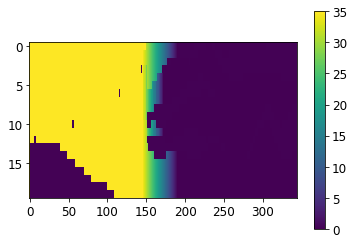

In [182]:
# ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
# for v in np.argwhere(ocean_grid):
#     ibound[v[0],v[1],:v[2]]=0
# head_inland =-10.
head_inland = min([np.min(np.array(v)[:,3]) for k,v in ghb_data_inland.items()])
# ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
for lay in range(nlay):
    for row in range(nrow):
        col = int(np.argwhere(ocean_grid[lay,row,:])[0])
        ibound[lay,row,:col]=0
for v in inds:
    ibound[v[0],v[1],:v[2]]=0
# ibound[z_m_vert[1:,:,:]>0]=0
ibound[m_empty.modelgrid.zcellcenters > -1] = 0 
ibound[layer_mapping_ind==6]=0


strt = np.ones_like(ibound)*head_inland

# sconc=np.ones((nlay,nrow,ncol),dtype=np.float)*Cfresh
# sconc[ocean_grid] = Csalt
# # interface_start = np.array(get_line(ocean_line.T[0,1:],[nlay-1,int(ncol/2)],allrows=1))
# for v in ocean_line.T:
#     sconc[v[0],v[1],:v[2]]=Csalt
# sconc[np.logical_or(salt_180,salt_400)] = Csalt
    
sconc=np.ones((nlay,nrow,ncol),dtype=np.float)*Cfresh
sconc[np.isin(kj_lay_red,(3,1))] = saltgrad_180[np.isin(kj_lay_red,(3,1))]
sconc[np.isin(kj_lay_red,(5,1))] = saltgrad_400[np.isin(kj_lay_red,(5,1))]
# sconc[layer_mapping_ind==1] =Csalt
sconc[ocean_grid] = Csalt
# interface_start = np.array(get_line(ocean_line.T[0,1:],[nlay-1,int(ncol/2)],allrows=1))
for v in ocean_line.T:
    sconc[v[0],v[1],:v[2]]=Csalt
    
    
    

icbund = np.ones((nlay, nrow, ncol), dtype=np.int)
icbund[np.where(ibound==-1)] = -1


plt.imshow(sconc[:,0,:],interpolation='nearest')
plt.gca().set_aspect(10)
plt.colorbar()
plt.show()

In [196]:
sconc.min()

0.0

In [183]:
# In[9]:

#Output control
oc_data = {}
for kper in range(nper):
    oc_data[(kper,0)] = ['save head','save budget']


# In[10]:

#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)
ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)

chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)

# rch = flopy.modflow.ModflowRch(m, rech=rech_data)
# wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)
# riv = flopy.modflow.ModflowRiv(m, stress_period_data=riv_data)
# Add LPF package to the MODFLOW model
ipakcb = 53
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=0,laywet=0,
                              ss=ss,sy=sy)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
timprs = np.cumsum(m.DIS.perlen.array)
btn = flopy.mt3d.Mt3dBtn(m,
                         laycon=lpf.laytyp, htop=henry_top,
                         dz=dis.thickness.get_value(), prsity=por, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
# adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1 )
adv = flopy.mt3d.Mt3dAdv(m, mixelm=0,nadvfd=0 )

dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=3, cclose=1e-4)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data,mxss=len(ssm_data[0])*nper)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=0,
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)




****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfchd.ModflowChd'> <class 'flopy.modflow.mfchd.ModflowChd'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfpcg.ModflowPcg'> <class 'flopy.modflow.mfpcg.ModflowPcg'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...
****Warning -- two packages of the same type:  <cl

In [184]:
%%time
writeyn= True
runyn = True
#Write input
if writeyn:
    print('writing to',m.model_ws)
    m.write_input()

# Try to delete the output files, to prevent accidental use of older files

f_delete = [os.path.join(model_ws,'MT3D.CNF'),
            os.path.join(model_ws,'MT3D001.MAS'),
            os.path.join(model_ws, 'MT3D001.UCN'),
            os.path.join(model_ws, modelname + '.hds'),
            os.path.join(model_ws, modelname + '.cbc')]

for f in f_delete:
    try:
        os.remove(f)
    except:
        pass

#%%
import datetime

if runyn:
    #Run model
    ts = make_timestamp()
    v = m.run_model(silent=False, report=True)
    for idx in range(-3, 0):
        print(v[1][idx])
else:
    print('Not running model!')
# In[14]:

writing to /scratch/users/ianpg/SWIlarge/work/NM_xsection

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  GHB
   Package:  CHD
   Package:  LPF
   Package:  PCG
   Package:  OC
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  GCG
   Package:  SSM
   Package:  VDF
 
FloPy is using the following  executable to run the model: /home/groups/rknight/swtv4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: NM.nam       

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1125E-01  [K,I,J]    4    1  145
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3199E-04  [K,I,J]    3    1  161
 Transport Step:   28   Step Size:   5.046     Total Elapsed Time:   126.89    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1101E-01  [K,I,J]    4    1  145
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3132E-04  [K,I,J]    3    1  161
 Transport Step:   29   Step Size:   5.046     Total Elapsed Time:   131.93    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1077E-01  [K,I,J]    4    1  145
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3063E-04  [K,I,J]    3    1  161
 Transport Step:   30   Step Size:   5.046     Total Elapsed Time:   136.98    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1054E-01  [K,I,J]    4    1  145
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2995E-04  [K,I,J]    3    1  161
 Transport Step:   31   Step Size:   5.046     Total Elapsed Time:   142.03    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5742E-02  [K,I,J]   10    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1904E-04  [K,I,J]    3    1  161
 Transport Step:   23   Step Size:   4.972     Total Elapsed Time:   296.84    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5663E-02  [K,I,J]   10    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1859E-04  [K,I,J]    3    1  161
 Transport Step:   24   Step Size:   4.972     Total Elapsed Time:   301.81    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5586E-02  [K,I,J]   10    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1815E-04  [K,I,J]    3    1  161
 Transport Step:   25   Step Size:   4.972     Total Elapsed Time:   306.78    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5508E-02  [K,I,J]   10    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1773E-04  [K,I,J]    3    1  161
 Transport Step:   26   Step Size:   4.972     Total Elapsed Time:   311.76    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3602E-02  [K,I,J]    2    1  171
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8905E-05  [K,I,J]    3    1  161
 Transport Step:   20   Step Size:   4.650     Total Elapsed Time:   458.30    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3565E-02  [K,I,J]    2    1  171
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8741E-05  [K,I,J]    3    1  161
 Transport Step:   21   Step Size:   4.650     Total Elapsed Time:   462.95    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3527E-02  [K,I,J]    2    1  171
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8581E-05  [K,I,J]    3    1  161
 Transport Step:   22   Step Size:   4.650     Total Elapsed Time:   467.60    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3488E-02  [K,I,J]    2    1  171
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8426E-05  [K,I,J]    3    1  161
 Transport Step:   23   Step Size:   4.650     Total Elapsed Time:   472.25    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2651E-02  [K,I,J]    2    1  173
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5119E-05  [K,I,J]    3    1  161
 Transport Step:   15   Step Size:   4.650     Total Elapsed Time:   617.25    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2634E-02  [K,I,J]    2    1  174
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5043E-05  [K,I,J]    3    1  161
 Transport Step:   16   Step Size:   4.650     Total Elapsed Time:   621.90    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2617E-02  [K,I,J]    2    1  174
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4968E-05  [K,I,J]    3    1  161
 Transport Step:   17   Step Size:   4.650     Total Elapsed Time:   626.56    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2599E-02  [K,I,J]    2    1  174
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4894E-05  [K,I,J]    3    1  161
 Transport Step:   18   Step Size:   4.650     Total Elapsed Time:   631.21    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2078E-02  [K,I,J]   11    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3861E-05  [K,I,J]    3    1  161
 Transport Step:    9   Step Size:   4.679     Total Elapsed Time:   772.05    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2065E-02  [K,I,J]   11    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3805E-05  [K,I,J]    3    1  161
 Transport Step:   10   Step Size:   4.679     Total Elapsed Time:   776.73    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2053E-02  [K,I,J]   11    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3750E-05  [K,I,J]    3    1  161
 Transport Step:   11   Step Size:   4.679     Total Elapsed Time:   781.41    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2040E-02  [K,I,J]   11    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3696E-05  [K,I,J]    3    1  161
 Transport Step:   12   Step Size:   4.679     Total Elapsed Time:   786.09    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1906E-02  [K,I,J]    2    1  156
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2672E-05  [K,I,J]   14    1  155
 Transport Step:    4   Step Size:   4.753     Total Elapsed Time:   931.49    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1916E-02  [K,I,J]    2    1  156
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2640E-05  [K,I,J]   14    1  155
 Transport Step:    5   Step Size:   4.750     Total Elapsed Time:   936.24    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1919E-02  [K,I,J]    2    1  156
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2624E-05  [K,I,J]   14    1  155
 Transport Step:    6   Step Size:   4.749     Total Elapsed Time:   940.99    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1918E-02  [K,I,J]    2    1  156
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2615E-05  [K,I,J]   14    1  155
 Transport Step:    7   Step Size:   4.749     Total Elapsed Time:   945.73    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1683E-02  [K,I,J]   13    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2774E-05  [K,I,J]   15    1  155
 Transport Step:    3   Step Size:   5.053     Total Elapsed Time:   1109.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1632E-02  [K,I,J]   13    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2578E-05  [K,I,J]   15    1  155
 Transport Step:    4   Step Size:   5.037     Total Elapsed Time:   1115.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1614E-02  [K,I,J]   13    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2519E-05  [K,I,J]   15    1  155
 Transport Step:    5   Step Size:   5.032     Total Elapsed Time:   1120.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1604E-02  [K,I,J]   13    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2494E-05  [K,I,J]   15    1  155
 Transport Step:    6   Step Size:   5.030     Total Elapsed Time:   1125.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1434E-02  [K,I,J]   13    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2219E-05  [K,I,J]   15    1  155
 Transport Step:    4   Step Size:   5.089     Total Elapsed Time:   1297.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1423E-02  [K,I,J]   13    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2190E-05  [K,I,J]   15    1  155
 Transport Step:    5   Step Size:   5.086     Total Elapsed Time:   1302.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1417E-02  [K,I,J]   13    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2176E-05  [K,I,J]   15    1  155
 Transport Step:    6   Step Size:   5.085     Total Elapsed Time:   1308.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1412E-02  [K,I,J]   13    1  157
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2168E-05  [K,I,J]   15    1  155
 Transport Step:    7   Step Size:   5.085     Total Elapsed Time:   1313.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1295E-02  [K,I,J]   13    1  158
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1977E-05  [K,I,J]   13    1  157
 Transport Step:    2   Step Size:   5.129     Total Elapsed Time:   1470.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1323E-02  [K,I,J]   13    1  158
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2064E-05  [K,I,J]   13    1  157
 Transport Step:    3   Step Size:   5.125     Total Elapsed Time:   1475.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1319E-02  [K,I,J]   13    1  158
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2053E-05  [K,I,J]   13    1  157
 Transport Step:    4   Step Size:   5.124     Total Elapsed Time:   1480.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1315E-02  [K,I,J]   13    1  158
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2047E-05  [K,I,J]   13    1  157
 Transport Step:    5   Step Size:   5.124     Total Elapsed Time:   1485.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1085E-02  [K,I,J]   13    1  158
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1382E-05  [K,I,J]   13    1  157
 Transport Step:    4   Step Size:   4.795     Total Elapsed Time:   1662.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1077E-02  [K,I,J]   13    1  158
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1367E-05  [K,I,J]   13    1  157
 Transport Step:    5   Step Size:   4.793     Total Elapsed Time:   1666.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1072E-02  [K,I,J]   13    1  158
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1360E-05  [K,I,J]   13    1  157
 Transport Step:    6   Step Size:   4.792     Total Elapsed Time:   1671.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1069E-02  [K,I,J]   13    1  158
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1357E-05  [K,I,J]   13    1  157
 Transport Step:    7   Step Size:   4.792     Total Elapsed Time:   1676.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1346E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1290E-05  [K,I,J]   16    1  342
 Transport Step:    4   Step Size:   4.933     Total Elapsed Time:   1844.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1391E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1061E-05  [K,I,J]   13    1  157
 Transport Step:    5   Step Size:   4.928     Total Elapsed Time:   1849.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1398E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1049E-05  [K,I,J]   13    1  157
 Transport Step:    6   Step Size:   4.926     Total Elapsed Time:   1854.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1388E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1044E-05  [K,I,J]   13    1  157
 Transport Step:    7   Step Size:   4.925     Total Elapsed Time:   1859.5    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1058E-02  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7536E-06  [K,I,J]   13    1  157
 Transport Step:    5   Step Size:   4.564     Total Elapsed Time:   2030.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1056E-02  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7555E-06  [K,I,J]   13    1  157
 Transport Step:    6   Step Size:   4.564     Total Elapsed Time:   2035.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1052E-02  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7569E-06  [K,I,J]   13    1  157
 Transport Step:    7   Step Size:   4.564     Total Elapsed Time:   2039.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1049E-02  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7579E-06  [K,I,J]   13    1  157
 Transport Step:    8   Step Size:   4.564     Total Elapsed Time:   2044.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9406E-03  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7204E-06  [K,I,J]   13    1  157
 Transport Step:   40   Step Size:   4.138     Total Elapsed Time:   2190.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8503E-03  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5405E-06  [K,I,J]   13    1  157
 Transport Step:   41   Step Size:  4.5475E-13 Total Elapsed Time:   2190.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   13

  STRESS PERIOD   13 TIME STEP    1 FROM TIME =   2190.0     TO    2372.5    

 Transport Step:    1   Step Size:   4.564     Total Elapsed Time:   2194.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8806E-03  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1748E-05  [K,I,J]   17    1  345
 Transport Step:    2   Step Size:   3.997     Total Elapsed Time:   2198.6    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6362E-03  [K,I,J]   14    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5445E-06  [K,I,J]   13    1  157
 Transport Step:   34   Step Size:   4.040     Total Elapsed Time:   2327.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6352E-03  [K,I,J]   14    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5432E-06  [K,I,J]   13    1  157
 Transport Step:   35   Step Size:   4.040     Total Elapsed Time:   2331.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6341E-03  [K,I,J]   14    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5418E-06  [K,I,J]   13    1  157
 Transport Step:   36   Step Size:   4.040     Total Elapsed Time:   2335.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6331E-03  [K,I,J]   14    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5404E-06  [K,I,J]   13    1  157
 Transport Step:   37   Step Size:   4.040     Total Elapsed Time:   2340.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6397E-03  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4226E-06  [K,I,J]    6    1  208
 Transport Step:   23   Step Size:   3.924     Total Elapsed Time:   2462.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6383E-03  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4237E-06  [K,I,J]    6    1  208
 Transport Step:   24   Step Size:   3.924     Total Elapsed Time:   2466.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6369E-03  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4247E-06  [K,I,J]    6    1  208
 Transport Step:   25   Step Size:   3.924     Total Elapsed Time:   2470.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6354E-03  [K,I,J]   14    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4257E-06  [K,I,J]    6    1  208
 Transport Step:   26   Step Size:   3.924     Total Elapsed Time:   2474.7    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5903E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5175E-06  [K,I,J]    6    1  208
 Transport Step:   13   Step Size:   3.866     Total Elapsed Time:   2605.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5901E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5182E-06  [K,I,J]    6    1  208
 Transport Step:   14   Step Size:   3.866     Total Elapsed Time:   2609.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5898E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5188E-06  [K,I,J]    6    1  208
 Transport Step:   15   Step Size:   3.866     Total Elapsed Time:   2613.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5896E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5195E-06  [K,I,J]    6    1  208
 Transport Step:   16   Step Size:   3.866     Total Elapsed Time:   2616.9    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1140E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4552E-08  [K,I,J]    6    1  208
 Transport Step:   49   Step Size:  4.5475E-13 Total Elapsed Time:   2737.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   16

  STRESS PERIOD   16 TIME STEP    1 FROM TIME =   2737.5     TO    2920.0    

 Transport Step:    1   Step Size:   3.866     Total Elapsed Time:   2741.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5614E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5379E-06  [K,I,J]   17    1  345
 Transport Step:    2   Step Size:   4.193     Total Elapsed Time:   2745.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6265E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6431E-06  [K,I,J]    6    1  208
 Transport Step:    3   Step Size:   4.192     Total Elapsed Time:   2749.8    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6139E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6886E-06  [K,I,J]    6    1  208
 Transport Step:   35   Step Size:   4.191     Total Elapsed Time:   2883.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6135E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6891E-06  [K,I,J]    6    1  208
 Transport Step:   36   Step Size:   4.191     Total Elapsed Time:   2888.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6130E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6896E-06  [K,I,J]    6    1  208
 Transport Step:   37   Step Size:   4.191     Total Elapsed Time:   2892.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6125E-03  [K,I,J]   12    1  159
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6900E-06  [K,I,J]    6    1  208
 Transport Step:   38   Step Size:   4.191     Total Elapsed Time:   2896.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1933E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4125E-06  [K,I,J]   17    1  345
 Transport Step:   25   Step Size:   5.356     Total Elapsed Time:   3053.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1909E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3966E-06  [K,I,J]   17    1  345
 Transport Step:   26   Step Size:   5.356     Total Elapsed Time:   3058.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1885E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3815E-06  [K,I,J]   17    1  345
 Transport Step:   27   Step Size:   5.356     Total Elapsed Time:   3063.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1863E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3748E-06  [K,I,J]   13    1  157
 Transport Step:   28   Step Size:   5.356     Total Elapsed Time:   3069.2    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1596E-02  [K,I,J]    3    1  164
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5675E-06  [K,I,J]   17    1  345
 Transport Step:   25   Step Size:   5.557     Total Elapsed Time:   3241.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1567E-02  [K,I,J]    3    1  164
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5478E-06  [K,I,J]   17    1  345
 Transport Step:   26   Step Size:   5.557     Total Elapsed Time:   3247.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1539E-02  [K,I,J]    3    1  163
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5289E-06  [K,I,J]   17    1  345
 Transport Step:   27   Step Size:   5.557     Total Elapsed Time:   3252.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1520E-02  [K,I,J]    3    1  163
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5107E-06  [K,I,J]   17    1  345
 Transport Step:   28   Step Size:   5.557     Total Elapsed Time:   3258.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9880E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2175E-06  [K,I,J]   13    1  157
 Transport Step:   28   Step Size:   5.192     Total Elapsed Time:   3430.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9830E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2171E-06  [K,I,J]   13    1  157
 Transport Step:   29   Step Size:   5.192     Total Elapsed Time:   3435.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9781E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2168E-06  [K,I,J]   13    1  157
 Transport Step:   30   Step Size:   5.192     Total Elapsed Time:   3441.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9732E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2164E-06  [K,I,J]   13    1  157
 Transport Step:   31   Step Size:   5.192     Total Elapsed Time:   3446.3    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7927E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1909E-06  [K,I,J]   13    1  157
 Transport Step:   30   Step Size:   5.043     Total Elapsed Time:   3618.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7889E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1904E-06  [K,I,J]   13    1  157
 Transport Step:   31   Step Size:   5.043     Total Elapsed Time:   3624.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7851E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1899E-06  [K,I,J]   13    1  157
 Transport Step:   32   Step Size:   5.043     Total Elapsed Time:   3629.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7813E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1895E-06  [K,I,J]   13    1  157
 Transport Step:   33   Step Size:   5.043     Total Elapsed Time:   3634.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7020E-03  [K,I,J]    4    1  163
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1759E-06  [K,I,J]   13    1  157
 Transport Step:   30   Step Size:   4.843     Total Elapsed Time:   3795.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6999E-03  [K,I,J]    4    1  163
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1753E-06  [K,I,J]   13    1  157
 Transport Step:   31   Step Size:   4.843     Total Elapsed Time:   3800.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6978E-03  [K,I,J]    4    1  163
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1748E-06  [K,I,J]   13    1  157
 Transport Step:   32   Step Size:   4.843     Total Elapsed Time:   3805.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6956E-03  [K,I,J]    4    1  163
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1742E-06  [K,I,J]   13    1  157
 Transport Step:   33   Step Size:   4.843     Total Elapsed Time:   3810.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6395E-03  [K,I,J]    4    1  163
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1811E-06  [K,I,J]   13    1  157
 Transport Step:   26   Step Size:   5.201     Total Elapsed Time:   3967.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6381E-03  [K,I,J]    4    1  163
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1807E-06  [K,I,J]   13    1  157
 Transport Step:   27   Step Size:   5.201     Total Elapsed Time:   3972.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6366E-03  [K,I,J]    4    1  163
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1802E-06  [K,I,J]   13    1  157
 Transport Step:   28   Step Size:   5.201     Total Elapsed Time:   3977.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6352E-03  [K,I,J]    4    1  163
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1797E-06  [K,I,J]   13    1  157
 Transport Step:   29   Step Size:   5.201     Total Elapsed Time:   3983.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7061E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1774E-06  [K,I,J]   16    1  341
 Transport Step:   24   Step Size:   5.322     Total Elapsed Time:   4142.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7034E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1738E-06  [K,I,J]   16    1  341
 Transport Step:   25   Step Size:   5.322     Total Elapsed Time:   4148.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7007E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1704E-06  [K,I,J]   16    1  341
 Transport Step:   26   Step Size:   5.322     Total Elapsed Time:   4153.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6980E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1673E-06  [K,I,J]   16    1  341
 Transport Step:   27   Step Size:   5.322     Total Elapsed Time:   4158.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5798E-03  [K,I,J]    3    1  162
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1734E-06  [K,I,J]   14    1  213
 Transport Step:   26   Step Size:   4.664     Total Elapsed Time:   4319.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5692E-03  [K,I,J]    3    1  162
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1742E-06  [K,I,J]   14    1  213
 Transport Step:   27   Step Size:   4.664     Total Elapsed Time:   4324.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5589E-03  [K,I,J]    3    1  162
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1749E-06  [K,I,J]   14    1  213
 Transport Step:   28   Step Size:   4.664     Total Elapsed Time:   4328.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5488E-03  [K,I,J]    3    1  162
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1756E-06  [K,I,J]   14    1  213
 Transport Step:   29   Step Size:   4.664     Total Elapsed Time:   4333.3    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1107E-02  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4614E-06  [K,I,J]    3    1  161
 Transport Step:   24   Step Size:   4.424     Total Elapsed Time:   4486.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1094E-02  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4569E-06  [K,I,J]    3    1  161
 Transport Step:   25   Step Size:   4.424     Total Elapsed Time:   4490.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1081E-02  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4525E-06  [K,I,J]    3    1  161
 Transport Step:   26   Step Size:   4.424     Total Elapsed Time:   4495.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1069E-02  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4481E-06  [K,I,J]    3    1  161
 Transport Step:   27   Step Size:   4.424     Total Elapsed Time:   4499.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1058E-02  [K,I,J]    4    1  162
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1049E-05  [K,I,J]    3    1  161
 Transport Step:   16   Step Size:   4.378     Total Elapsed Time:   4632.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1045E-02  [K,I,J]    4    1  162
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1033E-05  [K,I,J]    3    1  161
 Transport Step:   17   Step Size:   4.378     Total Elapsed Time:   4636.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1032E-02  [K,I,J]    4    1  162
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1017E-05  [K,I,J]    3    1  161
 Transport Step:   18   Step Size:   4.378     Total Elapsed Time:   4641.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1020E-02  [K,I,J]    4    1  162
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1002E-05  [K,I,J]    3    1  161
 Transport Step:   19   Step Size:   4.378     Total Elapsed Time:   4645.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1523E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1493E-05  [K,I,J]    3    1  161
 Transport Step:   11   Step Size:   4.372     Total Elapsed Time:   4793.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1510E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1467E-05  [K,I,J]    3    1  161
 Transport Step:   12   Step Size:   4.372     Total Elapsed Time:   4797.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1497E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1442E-05  [K,I,J]    3    1  161
 Transport Step:   13   Step Size:   4.372     Total Elapsed Time:   4801.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1484E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1417E-05  [K,I,J]    3    1  161
 Transport Step:   14   Step Size:   4.372     Total Elapsed Time:   4806.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1619E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1462E-05  [K,I,J]    3    1  161
 Transport Step:    3   Step Size:   4.540     Total Elapsed Time:   4940.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1745E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1684E-05  [K,I,J]    3    1  161
 Transport Step:    4   Step Size:   4.548     Total Elapsed Time:   4945.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1790E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1763E-05  [K,I,J]    3    1  161
 Transport Step:    5   Step Size:   4.550     Total Elapsed Time:   4950.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1800E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1780E-05  [K,I,J]    3    1  161
 Transport Step:    6   Step Size:   4.551     Total Elapsed Time:   4954.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1842E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6331E-08  [K,I,J]   14    1  213
 Transport Step:   42   Step Size:  9.0949E-13 Total Elapsed Time:   5110.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   29

  STRESS PERIOD   29 TIME STEP    1 FROM TIME =   5110.0     TO    5292.5    

 Transport Step:    1   Step Size:   4.552     Total Elapsed Time:   5114.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1447E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2173E-05  [K,I,J]   17    1  345
 Transport Step:    2   Step Size:   4.219     Total Elapsed Time:   5118.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1587E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1528E-05  [K,I,J]   14    1  213
 Transport Step:    3   Step Size:   4.252     Total Elapsed Time:   5123.0    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1265E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1783E-05  [K,I,J]   14    1  213
 Transport Step:   35   Step Size:   4.265     Total Elapsed Time:   5259.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1250E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1785E-05  [K,I,J]   14    1  213
 Transport Step:   36   Step Size:   4.265     Total Elapsed Time:   5263.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1235E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1788E-05  [K,I,J]   14    1  213
 Transport Step:   37   Step Size:   4.265     Total Elapsed Time:   5268.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1220E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1790E-05  [K,I,J]   14    1  213
 Transport Step:   38   Step Size:   4.265     Total Elapsed Time:   5272.3    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5902E-03  [K,I,J]   12    1  171
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1932E-05  [K,I,J]   14    1  213
 Transport Step:   26   Step Size:   4.684     Total Elapsed Time:   5413.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5894E-03  [K,I,J]   12    1  171
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1934E-05  [K,I,J]   14    1  213
 Transport Step:   27   Step Size:   4.684     Total Elapsed Time:   5418.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5887E-03  [K,I,J]   12    1  171
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1936E-05  [K,I,J]   14    1  213
 Transport Step:   28   Step Size:   4.684     Total Elapsed Time:   5423.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5879E-03  [K,I,J]   12    1  171
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1939E-05  [K,I,J]   14    1  213
 Transport Step:   29   Step Size:   4.684     Total Elapsed Time:   5428.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5595E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1655E-05  [K,I,J]   14    1  213
 Transport Step:   23   Step Size:   5.405     Total Elapsed Time:   5598.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5462E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1657E-05  [K,I,J]   14    1  213
 Transport Step:   24   Step Size:   5.405     Total Elapsed Time:   5604.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5331E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1659E-05  [K,I,J]   14    1  213
 Transport Step:   25   Step Size:   5.405     Total Elapsed Time:   5609.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5274E-03  [K,I,J]   15    1  165
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1660E-05  [K,I,J]   14    1  213
 Transport Step:   26   Step Size:   5.405     Total Elapsed Time:   5615.0    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4585E-03  [K,I,J]   15    1  165
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1241E-05  [K,I,J]   14    1  213
 Transport Step:   27   Step Size:   5.015     Total Elapsed Time:   5793.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4580E-03  [K,I,J]   15    1  165
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1243E-05  [K,I,J]   14    1  213
 Transport Step:   28   Step Size:   5.015     Total Elapsed Time:   5798.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4575E-03  [K,I,J]   15    1  165
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1244E-05  [K,I,J]   14    1  213
 Transport Step:   29   Step Size:   5.015     Total Elapsed Time:   5803.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4570E-03  [K,I,J]   15    1  165
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1245E-05  [K,I,J]   14    1  213
 Transport Step:   30   Step Size:   5.015     Total Elapsed Time:   5808.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9540E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8726E-06  [K,I,J]   14    1  213
 Transport Step:   27   Step Size:   5.258     Total Elapsed Time:   5981.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9429E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8739E-06  [K,I,J]   14    1  213
 Transport Step:   28   Step Size:   5.258     Total Elapsed Time:   5987.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9319E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8751E-06  [K,I,J]   14    1  213
 Transport Step:   29   Step Size:   5.258     Total Elapsed Time:   5992.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9212E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8763E-06  [K,I,J]   14    1  213
 Transport Step:   30   Step Size:   5.258     Total Elapsed Time:   5997.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8475E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7012E-06  [K,I,J]   14    1  213
 Transport Step:   26   Step Size:   5.062     Total Elapsed Time:   6154.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8404E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7022E-06  [K,I,J]   14    1  213
 Transport Step:   27   Step Size:   5.062     Total Elapsed Time:   6159.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8334E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7032E-06  [K,I,J]   14    1  213
 Transport Step:   28   Step Size:   5.062     Total Elapsed Time:   6164.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8265E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7041E-06  [K,I,J]   14    1  213
 Transport Step:   29   Step Size:   5.062     Total Elapsed Time:   6169.5    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3879E-03  [K,I,J]   14    1  170
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9079E-06  [K,I,J]   14    1  213
 Transport Step:   23   Step Size:   4.698     Total Elapsed Time:   6313.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3877E-03  [K,I,J]   14    1  170
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9085E-06  [K,I,J]   14    1  213
 Transport Step:   24   Step Size:   4.698     Total Elapsed Time:   6318.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3875E-03  [K,I,J]   14    1  170
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9091E-06  [K,I,J]   14    1  213
 Transport Step:   25   Step Size:   4.698     Total Elapsed Time:   6322.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3873E-03  [K,I,J]   14    1  170
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9097E-06  [K,I,J]   14    1  213
 Transport Step:   26   Step Size:   4.698     Total Elapsed Time:   6327.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3863E-03  [K,I,J]   14    1  170
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9530E-06  [K,I,J]   14    1  213
 Transport Step:   18   Step Size:   4.793     Total Elapsed Time:   6473.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3862E-03  [K,I,J]   14    1  170
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9534E-06  [K,I,J]   14    1  213
 Transport Step:   19   Step Size:   4.793     Total Elapsed Time:   6478.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3860E-03  [K,I,J]   14    1  170
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9539E-06  [K,I,J]   14    1  213
 Transport Step:   20   Step Size:   4.793     Total Elapsed Time:   6483.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3858E-03  [K,I,J]   14    1  170
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9543E-06  [K,I,J]   14    1  213
 Transport Step:   21   Step Size:   4.793     Total Elapsed Time:   6488.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6770E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1160E-05  [K,I,J]   14    1  213
 Transport Step:   13   Step Size:   4.478     Total Elapsed Time:   6628.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6690E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1161E-05  [K,I,J]   14    1  213
 Transport Step:   14   Step Size:   4.478     Total Elapsed Time:   6632.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6611E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1161E-05  [K,I,J]   14    1  213
 Transport Step:   15   Step Size:   4.478     Total Elapsed Time:   6637.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6532E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1162E-05  [K,I,J]   14    1  213
 Transport Step:   16   Step Size:   4.478     Total Elapsed Time:   6641.9    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1450E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1817E-05  [K,I,J]   14    1  213
 Transport Step:    6   Step Size:   4.523     Total Elapsed Time:   6779.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1449E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1837E-05  [K,I,J]   14    1  213
 Transport Step:    7   Step Size:   4.524     Total Elapsed Time:   6784.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1437E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1850E-05  [K,I,J]   14    1  213
 Transport Step:    8   Step Size:   4.524     Total Elapsed Time:   6788.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1420E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1858E-05  [K,I,J]   14    1  213
 Transport Step:    9   Step Size:   4.524     Total Elapsed Time:   6793.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9114E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1912E-05  [K,I,J]   14    1  213
 Transport Step:   41   Step Size:   1.677     Total Elapsed Time:   6935.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3361E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1202E-06  [K,I,J]   14    1  213
 Transport Step:   42   Step Size:  9.0949E-13 Total Elapsed Time:   6935.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   39

  STRESS PERIOD   39 TIME STEP    1 FROM TIME =   6935.0     TO    7117.5    

 Transport Step:    1   Step Size:   4.524     Total Elapsed Time:   6939.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9862E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2226E-05  [K,I,J]   17    1  345
 Transport Step:    2   Step Size:   4.680     Total Elapsed Time:   6944.2    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8064E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2580E-05  [K,I,J]   14    1  213
 Transport Step:   38   Step Size:   4.716     Total Elapsed Time:   7114.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.7943E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2581E-05  [K,I,J]   14    1  213
 Transport Step:   39   Step Size:   3.529     Total Elapsed Time:   7117.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5877E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1178E-05  [K,I,J]   14    1  213
 Transport Step:   40   Step Size:  9.0949E-13 Total Elapsed Time:   7117.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   40

  STRESS PERIOD   40 TIME STEP    1 FROM TIME =   7117.5     TO    7300.0    

 Transport Step:    1   Step Size:   4.716     Total Elapsed Time:   7122.2    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3497E-03  [K,I,J]   13    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1095E-05  [K,I,J]   14    1  213
 Transport Step:   37   Step Size:  9.0949E-13 Total Elapsed Time:   7300.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   41

  STRESS PERIOD   41 TIME STEP    1 FROM TIME =   7300.0     TO    7482.5    

 Transport Step:    1   Step Size:   5.113     Total Elapsed Time:   7305.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6593E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5649E-05  [K,I,J]   17    1  345
 Transport Step:    2   Step Size:   5.984     Total Elapsed Time:   7311.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1383E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2974E-05  [K,I,J]   16    1  342
 Transport Step:    3   Step Size:   5.834     Total Elapsed Time:   7316.9    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1942E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1207E-05  [K,I,J]   17    1  345
 Transport Step:    4   Step Size:   5.498     Total Elapsed Time:   7504.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1976E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1059E-05  [K,I,J]   17    1  345
 Transport Step:    5   Step Size:   5.494     Total Elapsed Time:   7510.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1973E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9782E-06  [K,I,J]   17    1  345
 Transport Step:    6   Step Size:   5.493     Total Elapsed Time:   7515.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1956E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9185E-06  [K,I,J]   17    1  345
 Transport Step:    7   Step Size:   5.492     Total Elapsed Time:   7521.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1175E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4988E-06  [K,I,J]   17    1  345
 Transport Step:    8   Step Size:   4.890     Total Elapsed Time:   7704.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1164E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4747E-06  [K,I,J]   14    1  213
 Transport Step:    9   Step Size:   4.890     Total Elapsed Time:   7709.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1152E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4762E-06  [K,I,J]   14    1  213
 Transport Step:   10   Step Size:   4.890     Total Elapsed Time:   7714.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1141E-02  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4777E-06  [K,I,J]   14    1  213
 Transport Step:   11   Step Size:   4.890     Total Elapsed Time:   7719.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8514E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5864E-06  [K,I,J]   14    1  213
 Transport Step:    4   Step Size:   4.960     Total Elapsed Time:   7867.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8419E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5883E-06  [K,I,J]   14    1  213
 Transport Step:    5   Step Size:   4.961     Total Elapsed Time:   7872.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8336E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5892E-06  [K,I,J]   14    1  213
 Transport Step:    6   Step Size:   4.961     Total Elapsed Time:   7877.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8259E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5898E-06  [K,I,J]   14    1  213
 Transport Step:    7   Step Size:   4.961     Total Elapsed Time:   7882.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6201E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5716E-06  [K,I,J]   14    1  213
 Transport Step:    2   Step Size:   5.027     Total Elapsed Time:   8040.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6185E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6403E-06  [K,I,J]   14    1  213
 Transport Step:    3   Step Size:   5.033     Total Elapsed Time:   8045.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6098E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6527E-06  [K,I,J]   14    1  213
 Transport Step:    4   Step Size:   5.034     Total Elapsed Time:   8050.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6032E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6571E-06  [K,I,J]   14    1  213
 Transport Step:    5   Step Size:   5.034     Total Elapsed Time:   8055.1    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4621E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6197E-06  [K,I,J]   14    1  213
 Transport Step:    4   Step Size:   4.958     Total Elapsed Time:   8232.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4589E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6204E-06  [K,I,J]   14    1  213
 Transport Step:    5   Step Size:   4.958     Total Elapsed Time:   8237.4    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4558E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6211E-06  [K,I,J]   14    1  213
 Transport Step:    6   Step Size:   4.958     Total Elapsed Time:   8242.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4526E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6216E-06  [K,I,J]   14    1  213
 Transport Step:    7   Step Size:   4.958     Total Elapsed Time:   8247.3    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3660E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5893E-06  [K,I,J]   14    1  213
 Transport Step:    2   Step Size:   4.887     Total Elapsed Time:   8404.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3608E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5806E-06  [K,I,J]   14    1  213
 Transport Step:    3   Step Size:   4.885     Total Elapsed Time:   8409.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3585E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5821E-06  [K,I,J]   14    1  213
 Transport Step:    4   Step Size:   4.885     Total Elapsed Time:   8414.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3563E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5832E-06  [K,I,J]   14    1  213
 Transport Step:    5   Step Size:   4.884     Total Elapsed Time:   8419.5    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2942E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5973E-06  [K,I,J]   14    1  213
 Transport Step:   37   Step Size:   4.884     Total Elapsed Time:   8575.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2925E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5976E-06  [K,I,J]   14    1  213
 Transport Step:   38   Step Size:   1.700     Total Elapsed Time:   8577.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1016E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2933E-07  [K,I,J]   14    1  213
 Transport Step:   39   Step Size:  1.8190E-12 Total Elapsed Time:   8577.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   48

  STRESS PERIOD   48 TIME STEP    1 FROM TIME =   8577.5     TO    8760.0    

 Transport Step:    1   Step Size:   4.884     Total Elapsed Time:   8582.4    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2895E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7667E-06  [K,I,J]   14    1  213
 Transport Step:   37   Step Size:   4.638     Total Elapsed Time:   8760.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2716E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6426E-06  [K,I,J]   14    1  213
 Transport Step:   38   Step Size:  1.8190E-12 Total Elapsed Time:   8760.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   49

  STRESS PERIOD   49 TIME STEP    1 FROM TIME =   8760.0     TO    8942.5    

 Transport Step:    1   Step Size:   4.943     Total Elapsed Time:   8764.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2956E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1268E-05  [K,I,J]   17    1  345
 Transport Step:    2   Step Size:   4.979     Total Elapsed Time:   8769.9    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1627E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1323E-06  [K,I,J]   14    1  213
 Transport Step:   38   Step Size:  1.8190E-12 Total Elapsed Time:   8942.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   50

  STRESS PERIOD   50 TIME STEP    1 FROM TIME =   8942.5     TO    9125.0    

 Transport Step:    1   Step Size:   5.003     Total Elapsed Time:   8947.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3150E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.9445E-06  [K,I,J]   14    1  213
 Transport Step:    2   Step Size:   5.174     Total Elapsed Time:   8952.7    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3323E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1021E-05  [K,I,J]   14    1  213
 Transport Step:    3   Step Size:   5.170     Total Elapsed Time:   8957.8    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3239E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1033E-05  [K,I,J]   14    1  213
 Transport Step:   35   Step Size:   5.169     Total Elapsed Time:   9123.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3237E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1033E-05  [K,I,J]   14    1  213
 Transport Step:   36   Step Size:   1.751     Total Elapsed Time:   9125.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1097E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.4797E-07  [K,I,J]   14    1  213
 Transport Step:   37   Step Size:  1.8190E-12 Total Elapsed Time:   9125.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   51

  STRESS PERIOD   51 TIME STEP    1 FROM TIME =   9125.0     TO    9307.5    

 Transport Step:    1   Step Size:   5.169     Total Elapsed Time:   9130.2    
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3183E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1108E-05  [K,I,J]   14    1  213
 Transport Step:   33   Step Size:   5.345     Total Elapsed Time:   9301.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3181E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1108E-05  [K,I,J]   14    1  213
 Transport Step:   34   Step Size:   5.345     Total Elapsed Time:   9306.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3179E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1109E-05  [K,I,J]   14    1  213
 Transport Step:   35   Step Size:  0.9249     Total Elapsed Time:   9307.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5502E-04  [K,I,J]   15    1  180
 Transport Step:   36   Step Size:  1.8190E-12 Total Elapsed Time:   9307.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   52

  STRESS PERIO

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2783E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8558E-06  [K,I,J]   14    1  213
 Transport Step:   32   Step Size:   5.190     Total Elapsed Time:   9473.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2758E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8564E-06  [K,I,J]   14    1  213
 Transport Step:   33   Step Size:   5.190     Total Elapsed Time:   9479.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2732E-03  [K,I,J]    2    1  155
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8570E-06  [K,I,J]   14    1  213
 Transport Step:   34   Step Size:   5.190     Total Elapsed Time:   9484.2    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2711E-03  [K,I,J]   14    1  188
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.8576E-06  [K,I,J]   14    1  213
 Transport Step:   35   Step Size:   5.190     Total Elapsed Time:   9489.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2488E-03  [K,I,J]   14    1  187
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6474E-06  [K,I,J]   14    1  213
 Transport Step:   30   Step Size:   5.044     Total Elapsed Time:   9641.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2487E-03  [K,I,J]   14    1  187
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6484E-06  [K,I,J]   14    1  213
 Transport Step:   31   Step Size:   5.044     Total Elapsed Time:   9646.5    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2486E-03  [K,I,J]   14    1  187
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6494E-06  [K,I,J]   14    1  213
 Transport Step:   32   Step Size:   5.044     Total Elapsed Time:   9651.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2485E-03  [K,I,J]   14    1  187
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6503E-06  [K,I,J]   14    1  213
 Transport Step:   33   Step Size:   5.044     Total Elapsed Time:   9656.6    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4471E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3705E-06  [K,I,J]   14    1  213
 Transport Step:   27   Step Size:   4.768     Total Elapsed Time:   9801.6    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4394E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3718E-06  [K,I,J]   14    1  213
 Transport Step:   28   Step Size:   4.768     Total Elapsed Time:   9806.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4318E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3730E-06  [K,I,J]   14    1  213
 Transport Step:   29   Step Size:   4.768     Total Elapsed Time:   9811.1    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4243E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3742E-06  [K,I,J]   14    1  213
 Transport Step:   30   Step Size:   4.768     Total Elapsed Time:   9815.9    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5787E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2679E-06  [K,I,J]   17    1  345
 Transport Step:   26   Step Size:   4.521     Total Elapsed Time:   9972.8    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5699E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2600E-06  [K,I,J]   17    1  345
 Transport Step:   27   Step Size:   4.521     Total Elapsed Time:   9977.3    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5612E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2525E-06  [K,I,J]   17    1  345
 Transport Step:   28   Step Size:   4.521     Total Elapsed Time:   9981.9    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5527E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.2454E-06  [K,I,J]   17    1  345
 Transport Step:   29   Step Size:   4.521     Total Elapsed Time:   9986.4    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2620E-03  [K,I,J]    4    1  165
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3770E-06  [K,I,J]   14    1  213
 Transport Step:   20   Step Size:   4.630     Total Elapsed Time:   10126.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2600E-03  [K,I,J]    4    1  165
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3779E-06  [K,I,J]   14    1  213
 Transport Step:   21   Step Size:   4.630     Total Elapsed Time:   10130.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2580E-03  [K,I,J]    4    1  165
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3787E-06  [K,I,J]   14    1  213
 Transport Step:   22   Step Size:   4.630     Total Elapsed Time:   10135.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2561E-03  [K,I,J]    4    1  165
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3794E-06  [K,I,J]   14    1  213
 Transport Step:   23   Step Size:   4.630     Total Elapsed Time:   10140.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.4019E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5608E-06  [K,I,J]   14    1  213
 Transport Step:   17   Step Size:   4.745     Total Elapsed Time:   10300.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3933E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5625E-06  [K,I,J]   14    1  213
 Transport Step:   18   Step Size:   4.745     Total Elapsed Time:   10305.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3849E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5642E-06  [K,I,J]   14    1  213
 Transport Step:   19   Step Size:   4.745     Total Elapsed Time:   10310.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3767E-03  [K,I,J]    2    1  154
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5658E-06  [K,I,J]   14    1  213
 Transport Step:   20   Step Size:   4.745     Total Elapsed Time:   10315.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2340E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5816E-06  [K,I,J]   14    1  213
 Transport Step:   16   Step Size:   4.820     Total Elapsed Time:   10480.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2339E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5818E-06  [K,I,J]   14    1  213
 Transport Step:   17   Step Size:   4.820     Total Elapsed Time:   10484.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2339E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5820E-06  [K,I,J]   14    1  213
 Transport Step:   18   Step Size:   4.820     Total Elapsed Time:   10489.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2338E-03  [K,I,J]   15    1  180
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5822E-06  [K,I,J]   14    1  213
 Transport Step:   19   Step Size:   4.820     Total Elapsed Time:   10494.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2268E-03  [K,I,J]   14    1  188
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5831E-06  [K,I,J]   14    1  213
 Transport Step:   12   Step Size:   4.898     Total Elapsed Time:   10644.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2267E-03  [K,I,J]   14    1  188
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5832E-06  [K,I,J]   14    1  213
 Transport Step:   13   Step Size:   4.898     Total Elapsed Time:   10649.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2267E-03  [K,I,J]   14    1  188
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5834E-06  [K,I,J]   14    1  213
 Transport Step:   14   Step Size:   4.898     Total Elapsed Time:   10654.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2266E-03  [K,I,J]   14    1  188
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5836E-06  [K,I,J]   14    1  213
 Transport Step:   15   Step Size:   4.898     Total Elapsed Time:   10658.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2249E-03  [K,I,J]   14    1  188
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5896E-06  [K,I,J]   14    1  213
 Transport Step:   10   Step Size:   4.898     Total Elapsed Time:   10812.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2248E-03  [K,I,J]   14    1  188
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5898E-06  [K,I,J]   14    1  213
 Transport Step:   11   Step Size:   4.898     Total Elapsed Time:   10817.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2248E-03  [K,I,J]   14    1  188
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5900E-06  [K,I,J]   14    1  213
 Transport Step:   12   Step Size:   4.898     Total Elapsed Time:   10822.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2247E-03  [K,I,J]   14    1  188
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5902E-06  [K,I,J]   14    1  213
 Transport Step:   13   Step Size:   4.898     Total Elapsed Time:   10827.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2279E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5954E-06  [K,I,J]   14    1  213
 Transport Step:    5   Step Size:   4.898     Total Elapsed Time:   10974.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2281E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5958E-06  [K,I,J]   14    1  213
 Transport Step:    6   Step Size:   4.898     Total Elapsed Time:   10979.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2283E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5960E-06  [K,I,J]   14    1  213
 Transport Step:    7   Step Size:   4.898     Total Elapsed Time:   10984.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2284E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.5962E-06  [K,I,J]   14    1  213
 Transport Step:    8   Step Size:   4.898     Total Elapsed Time:   10989.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2315E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6020E-06  [K,I,J]   14    1  213
 Transport Step:    2   Step Size:   4.898     Total Elapsed Time:   11142.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2316E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6021E-06  [K,I,J]   14    1  213
 Transport Step:    3   Step Size:   4.898     Total Elapsed Time:   11147.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2317E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6023E-06  [K,I,J]   14    1  213
 Transport Step:    4   Step Size:   4.898     Total Elapsed Time:   11152.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2318E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6025E-06  [K,I,J]   14    1  213
 Transport Step:    5   Step Size:   4.898     Total Elapsed Time:   11157.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2345E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6082E-06  [K,I,J]   14    1  213
 Transport Step:   37   Step Size:   4.898     Total Elapsed Time:   11314.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2346E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6084E-06  [K,I,J]   14    1  213
 Transport Step:   38   Step Size:   1.272     Total Elapsed Time:   11315.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6101E-04  [K,I,J]   16    1  179
 Transport Step:   39   Step Size:  1.8190E-12 Total Elapsed Time:   11315.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   63

  STRESS PERIOD   63 TIME STEP    1 FROM TIME =   11315.     TO    11498.    

 Transport Step:    1   Step Size:   4.898     Total Elapsed Time:   11320.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2239E-03  [K,I,J]   16    1  179
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2369E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6142E-06  [K,I,J]   14    1  213
 Transport Step:   34   Step Size:   4.898     Total Elapsed Time:   11482.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2370E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6143E-06  [K,I,J]   14    1  213
 Transport Step:   35   Step Size:   4.898     Total Elapsed Time:   11486.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2370E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6145E-06  [K,I,J]   14    1  213
 Transport Step:   36   Step Size:   4.898     Total Elapsed Time:   11491.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2371E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6147E-06  [K,I,J]   14    1  213
 Transport Step:   37   Step Size:   4.898     Total Elapsed Time:   11496.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2387E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6199E-06  [K,I,J]   14    1  213
 Transport Step:   32   Step Size:   4.898     Total Elapsed Time:   11650.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2388E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6201E-06  [K,I,J]   14    1  213
 Transport Step:   33   Step Size:   4.898     Total Elapsed Time:   11655.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2388E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6203E-06  [K,I,J]   14    1  213
 Transport Step:   34   Step Size:   4.898     Total Elapsed Time:   11660.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2388E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6204E-06  [K,I,J]   14    1  213
 Transport Step:   35   Step Size:   4.898     Total Elapsed Time:   11665.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2400E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6255E-06  [K,I,J]   14    1  213
 Transport Step:   28   Step Size:   4.898     Total Elapsed Time:   11817.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2400E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6256E-06  [K,I,J]   14    1  213
 Transport Step:   29   Step Size:   4.898     Total Elapsed Time:   11822.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2400E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6258E-06  [K,I,J]   14    1  213
 Transport Step:   30   Step Size:   4.898     Total Elapsed Time:   11827.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2400E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6259E-06  [K,I,J]   14    1  213
 Transport Step:   31   Step Size:   4.898     Total Elapsed Time:   11832.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2406E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6308E-06  [K,I,J]   14    1  213
 Transport Step:   25   Step Size:   4.898     Total Elapsed Time:   11985.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2406E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6310E-06  [K,I,J]   14    1  213
 Transport Step:   26   Step Size:   4.898     Total Elapsed Time:   11990.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2406E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6312E-06  [K,I,J]   14    1  213
 Transport Step:   27   Step Size:   4.898     Total Elapsed Time:   11995.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2406E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6313E-06  [K,I,J]   14    1  213
 Transport Step:   28   Step Size:   4.898     Total Elapsed Time:   12000.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2406E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6361E-06  [K,I,J]   14    1  213
 Transport Step:   22   Step Size:   4.898     Total Elapsed Time:   12153.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2406E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6362E-06  [K,I,J]   14    1  213
 Transport Step:   23   Step Size:   4.898     Total Elapsed Time:   12158.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2406E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6364E-06  [K,I,J]   14    1  213
 Transport Step:   24   Step Size:   4.898     Total Elapsed Time:   12163.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2406E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6365E-06  [K,I,J]   14    1  213
 Transport Step:   25   Step Size:   4.898     Total Elapsed Time:   12167.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2401E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6410E-06  [K,I,J]   14    1  213
 Transport Step:   19   Step Size:   4.898     Total Elapsed Time:   12316.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2401E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6411E-06  [K,I,J]   14    1  213
 Transport Step:   20   Step Size:   4.898     Total Elapsed Time:   12321.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2401E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6413E-06  [K,I,J]   14    1  213
 Transport Step:   21   Step Size:   4.898     Total Elapsed Time:   12326.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2400E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6414E-06  [K,I,J]   14    1  213
 Transport Step:   22   Step Size:   4.898     Total Elapsed Time:   12331.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2389E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6462E-06  [K,I,J]   14    1  213
 Transport Step:   18   Step Size:   4.898     Total Elapsed Time:   12498.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2389E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6464E-06  [K,I,J]   14    1  213
 Transport Step:   19   Step Size:   4.898     Total Elapsed Time:   12503.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2388E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6465E-06  [K,I,J]   14    1  213
 Transport Step:   20   Step Size:   4.898     Total Elapsed Time:   12508.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2388E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6467E-06  [K,I,J]   14    1  213
 Transport Step:   21   Step Size:   4.898     Total Elapsed Time:   12513.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2372E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6509E-06  [K,I,J]   14    1  213
 Transport Step:   15   Step Size:   4.898     Total Elapsed Time:   12666.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2372E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6510E-06  [K,I,J]   14    1  213
 Transport Step:   16   Step Size:   4.898     Total Elapsed Time:   12671.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2371E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6512E-06  [K,I,J]   14    1  213
 Transport Step:   17   Step Size:   4.898     Total Elapsed Time:   12676.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2371E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6513E-06  [K,I,J]   14    1  213
 Transport Step:   18   Step Size:   4.898     Total Elapsed Time:   12681.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2351E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6554E-06  [K,I,J]   14    1  213
 Transport Step:   12   Step Size:   4.898     Total Elapsed Time:   12834.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2350E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6555E-06  [K,I,J]   14    1  213
 Transport Step:   13   Step Size:   4.898     Total Elapsed Time:   12839.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2349E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6556E-06  [K,I,J]   14    1  213
 Transport Step:   14   Step Size:   4.898     Total Elapsed Time:   12844.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2349E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6558E-06  [K,I,J]   14    1  213
 Transport Step:   15   Step Size:   4.898     Total Elapsed Time:   12848.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2324E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6597E-06  [K,I,J]   14    1  213
 Transport Step:   10   Step Size:   4.898     Total Elapsed Time:   13002.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2324E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6598E-06  [K,I,J]   14    1  213
 Transport Step:   11   Step Size:   4.898     Total Elapsed Time:   13007.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2323E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6599E-06  [K,I,J]   14    1  213
 Transport Step:   12   Step Size:   4.898     Total Elapsed Time:   13012.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2322E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6600E-06  [K,I,J]   14    1  213
 Transport Step:   13   Step Size:   4.898     Total Elapsed Time:   13017.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2294E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6632E-06  [K,I,J]   14    1  213
 Transport Step:    5   Step Size:   4.898     Total Elapsed Time:   13164.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2294E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6636E-06  [K,I,J]   14    1  213
 Transport Step:    6   Step Size:   4.898     Total Elapsed Time:   13169.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2293E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6638E-06  [K,I,J]   14    1  213
 Transport Step:    7   Step Size:   4.898     Total Elapsed Time:   13174.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2292E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6639E-06  [K,I,J]   14    1  213
 Transport Step:    8   Step Size:   4.898     Total Elapsed Time:   13179.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2261E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6674E-06  [K,I,J]   14    1  213
 Transport Step:    2   Step Size:   4.898     Total Elapsed Time:   13332.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2260E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6675E-06  [K,I,J]   14    1  213
 Transport Step:    3   Step Size:   4.898     Total Elapsed Time:   13337.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2259E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6676E-06  [K,I,J]   14    1  213
 Transport Step:    4   Step Size:   4.898     Total Elapsed Time:   13342.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2258E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6678E-06  [K,I,J]   14    1  213
 Transport Step:    5   Step Size:   4.898     Total Elapsed Time:   13347.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2223E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6711E-06  [K,I,J]   14    1  213
 Transport Step:   37   Step Size:   4.898     Total Elapsed Time:   13504.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2222E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6712E-06  [K,I,J]   14    1  213
 Transport Step:   38   Step Size:   1.288     Total Elapsed Time:   13505.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.5847E-04  [K,I,J]   16    1  179
 Transport Step:   39   Step Size:  1.8190E-12 Total Elapsed Time:   13505.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   0.000      [K,I,J]    1    1    1

 STRESS PERIOD NO.   75

  STRESS PERIOD   75 TIME STEP    1 FROM TIME =   13505.     TO    13688.    

 Transport Step:    1   Step Size:   4.898     Total Elapsed Time:   13510.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2132E-03  [K,I,J]   16    1  179
 Outer Iter.  1

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2184E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6744E-06  [K,I,J]   14    1  213
 Transport Step:   34   Step Size:   4.898     Total Elapsed Time:   13672.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2182E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6745E-06  [K,I,J]   14    1  213
 Transport Step:   35   Step Size:   4.898     Total Elapsed Time:   13676.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2181E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6746E-06  [K,I,J]   14    1  213
 Transport Step:   36   Step Size:   4.898     Total Elapsed Time:   13681.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2180E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6747E-06  [K,I,J]   14    1  213
 Transport Step:   37   Step Size:   4.898     Total Elapsed Time:   13686.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2141E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6775E-06  [K,I,J]   14    1  213
 Transport Step:   32   Step Size:   4.898     Total Elapsed Time:   13840.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2140E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6776E-06  [K,I,J]   14    1  213
 Transport Step:   33   Step Size:   4.898     Total Elapsed Time:   13845.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2139E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6776E-06  [K,I,J]   14    1  213
 Transport Step:   34   Step Size:   4.898     Total Elapsed Time:   13850.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2138E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6777E-06  [K,I,J]   14    1  213
 Transport Step:   35   Step Size:   4.898     Total Elapsed Time:   13855.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2098E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6802E-06  [K,I,J]   14    1  213
 Transport Step:   28   Step Size:   4.898     Total Elapsed Time:   14007.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2097E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6803E-06  [K,I,J]   14    1  213
 Transport Step:   29   Step Size:   4.898     Total Elapsed Time:   14012.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2096E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6804E-06  [K,I,J]   14    1  213
 Transport Step:   30   Step Size:   4.898     Total Elapsed Time:   14017.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2094E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6805E-06  [K,I,J]   14    1  213
 Transport Step:   31   Step Size:   4.898     Total Elapsed Time:   14022.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2053E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6827E-06  [K,I,J]   14    1  213
 Transport Step:   25   Step Size:   4.898     Total Elapsed Time:   14175.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2052E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6828E-06  [K,I,J]   14    1  213
 Transport Step:   26   Step Size:   4.898     Total Elapsed Time:   14180.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2051E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6829E-06  [K,I,J]   14    1  213
 Transport Step:   27   Step Size:   4.898     Total Elapsed Time:   14185.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2049E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6829E-06  [K,I,J]   14    1  213
 Transport Step:   28   Step Size:   4.898     Total Elapsed Time:   14190.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2008E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6849E-06  [K,I,J]   14    1  213
 Transport Step:   22   Step Size:   4.897     Total Elapsed Time:   14343.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2007E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6850E-06  [K,I,J]   14    1  213
 Transport Step:   23   Step Size:   4.897     Total Elapsed Time:   14348.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2005E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6851E-06  [K,I,J]   14    1  213
 Transport Step:   24   Step Size:   4.897     Total Elapsed Time:   14353.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2004E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6851E-06  [K,I,J]   14    1  213
 Transport Step:   25   Step Size:   4.897     Total Elapsed Time:   14357.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1961E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6869E-06  [K,I,J]   14    1  213
 Transport Step:   20   Step Size:   4.897     Total Elapsed Time:   14511.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1960E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6869E-06  [K,I,J]   14    1  213
 Transport Step:   21   Step Size:   4.897     Total Elapsed Time:   14516.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1959E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6870E-06  [K,I,J]   14    1  213
 Transport Step:   22   Step Size:   4.897     Total Elapsed Time:   14521.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1957E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6870E-06  [K,I,J]   14    1  213
 Transport Step:   23   Step Size:   4.897     Total Elapsed Time:   14526.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1917E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6885E-06  [K,I,J]   14    1  213
 Transport Step:   15   Step Size:   4.897     Total Elapsed Time:   14673.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1915E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6885E-06  [K,I,J]   14    1  213
 Transport Step:   16   Step Size:   4.897     Total Elapsed Time:   14678.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1914E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6886E-06  [K,I,J]   14    1  213
 Transport Step:   17   Step Size:   4.897     Total Elapsed Time:   14683.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1913E-03  [K,I,J]   16    1  179
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6886E-06  [K,I,J]   14    1  213
 Transport Step:   18   Step Size:   4.897     Total Elapsed Time:   14688.    
 Outer Iter.  1  Inner Iter.  1:  Max. D

In [185]:
fname = model_ws.joinpath('MT3D001.UCN').as_posix()
anyvals= []
ucnobj = flopy.utils.binaryfile.UcnFile(fname,verbose=False)
# if kstpkper==None:
kstpkpers = ucnobj.get_kstpkper()
for kstpkper in kstpkpers:
    conc = ucnobj.get_data(kstpkper=kstpkper)
    anyvals.append(np.logical_and(conc < 100., conc>0.).any())
print(anyvals)


conc = ucnobj.get_data(kstpkper=kstpkpers[-1])
conc[conc > 100]=np.nan


fname = model_ws.joinpath(m.name +'.hds').as_posix()
hdobj = flopy.utils.binaryfile.HeadFile(fname,verbose=False)
kstpkpers = hdobj.get_kstpkper()
hd = hdobj.get_data(kstpkper=kstpkpers[-1])
hd[hd<-100]=np.nan

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


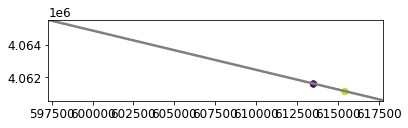

In [186]:
m_empty.modelgrid.plot()

plt.scatter(df_TDS.X_NAD83_UTM10N,df_TDS.Y_NAD83_UTM10N,c=np.log(df_TDS.conc))
# plt.scatter(df_TDS.loc[df_TDS.conc==260,'X_NAD83_UTM10N'],
#             df_TDS.loc[df_TDS.conc==260,'Y_NAD83_UTM10N'],c='r')

In [187]:
matshape_conc = conc.shape

df_TDS = pd.read_excel(datadir.joinpath('WQ','export_TDS_data.xlsx'))
df_TDS_2 = pd.read_excel(datadir.joinpath('WQ','wq_screen_export.xlsx'))
df_TDS_2 = df_TDS_2.loc[:,['WellID','Parameter','Units','Param_Value','Screen_Top_Elev_m',
                          'Screen_Bot_Elev_m','X_Nad83Z10m','Y_Nad83Z10m','TestDate']]
df_TDS2 = df_TDS_2.rename(columns={'WellID':'wellID',
                        'X_Nad83Z10m':'X_NAD83_UTM10N',
                        'Y_Nad83Z10m':'Y_NAD83_UTM10N',
                        'Screen_Top_Elev_m':'perf_start1_elev',
                        'Screen_Bot_Elev_m':'perf_end1_elev',
                        'TestDate':'date_rec',
                        'Parameter':'analyte',
                        'Units':'units',
                        'Param_Value':'conc'})
df_TDS = pd.concat((df_TDS,df_TDS2))




TDSij =[]
for x,y in zip(df_TDS.X_NAD83_UTM10N.values,df_TDS.Y_NAD83_UTM10N.values):
    try:
        TDSij.append(m_empty.modelgrid.intersect(x,y))
    except:
        TDSij.append((np.nan,np.nan))
df_TDS = df_TDS.assign(rowi=np.array(TDSij)[:,0])
df_TDS = df_TDS.assign(colj=np.array(TDSij)[:,1])


#Keep only valid data
tds_data_msk = np.logical_and(~np.logical_or(np.isnan(df_TDS.rowi),np.isnan(df_TDS.colj)),
                              df_TDS.perf_end1_elev>-150)
df_TDS = df_TDS.loc[tds_data_msk,:]
df_TDS = df_TDS.reset_index(drop=True)

#Find layers corresponding to screened interval
z_vert = m_empty.modelgrid.zvertices


top_vert_ind = np.zeros(len(df_TDS),dtype=int)
bot_vert_ind = np.zeros(len(df_TDS),dtype=int)
vert_ind_array = []
inds_raveled = []


for i in range(len(df_TDS)):
    entry = df_TDS.iloc[i]
    #Get indices
    top_vert_ind[i] =  np.argmin(np.abs(entry.perf_start1_elev -  z_vert[:,int(entry.rowi),int(entry.colj)]))
    bot_vert_ind[i] = np.argmin(np.abs(entry.perf_end1_elev -  z_vert[:,int(entry.rowi),int(entry.colj)]))
    if top_vert_ind[i]==bot_vert_ind[i]:
        top_vert_ind[i]-=1
    vert_ind_array.append(np.arange(top_vert_ind[i],bot_vert_ind[i]))
    
    
    inds_raveled.append(np.ravel_multi_index(((vert_ind_array[i]).astype(int),
                                 (np.ones(len(vert_ind_array[i]))*entry.rowi).astype(int),
                                 (np.ones(len(vert_ind_array[i]))*entry.colj).astype(int))
                                ,matshape_conc))
    if len(inds_raveled[i])==0:
        print(i)
    
# vert_ind_array = [np.arange(top,bot) for top,bot in zip(top_vert_ind,bot_vert_ind)]
df_TDS = df_TDS.assign(top_vert_ind=top_vert_ind)
df_TDS = df_TDS.assign(bot_vert_ind=bot_vert_ind)
df_TDS = df_TDS.assign(vert_ind_array=vert_ind_array)
df_TDS = df_TDS.assign(inds_raveled=inds_raveled)

d_tds_obs = np.reshape(df_TDS.loc[:,'conc'].values/1000,(1,-1))





In [188]:
starttime = start_m_yr + start_m_mo/12
times_sim = ucnobj.get_times()
times_real = starttime + np.array(times_sim)/365

diff = []
for time_load in times_real[::10]:

    loadtime_ind = np.argmin(np.abs(time_load-times_real))
    conc = ucnobj.get_data(totim=times_sim[loadtime_ind])
    conc[conc > 100]=np.nan


    d_tds = np.zeros((1,len(df_TDS)),dtype=np.float)
    for j,loc in enumerate(df_TDS.inds_raveled.values):
        d_tds[0,j] = conc.flatten()[loc].mean()


    diff.append(d_tds_obs - d_tds)

In [190]:
time_load =2019.3
# time_load =2000.

loadtime_ind = np.argmin(np.abs(time_load-times_real))
conc = ucnobj.get_data(totim=times_sim[loadtime_ind])
conc[conc > 100]=np.nan

fname = Path(m.model_ws).joinpath(m.name +'.hds').as_posix()
hdobj = flopy.utils.binaryfile.HeadFile(fname,verbose=False)


hd = hdobj.get_data(totim=times_sim[loadtime_ind])
hd[hd<-100]=np.nan



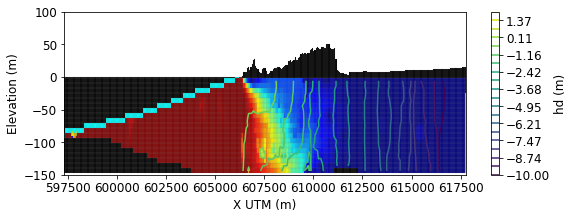

In [191]:
from matplotlib import cm

slicetype='Row'
slicenum= -1

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()
xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
csa = xsect.plot_array(conc,cmap='jet',vmin=0,vmax=35)
# c = plt.colorbar(csa)
# c.set_label('TDS (g/L)')


csa = xsect.contour_array(hd,levels= np.linspace(-10,2,20),cmap='viridis')
c = plt.colorbar(csa)
c.set_label('hd (m)')



# wel = xsect.plot_bc("CHD")
wel = xsect.plot_ibound()
wel = xsect.plot_bc("GHB")

x = np.ravel([np.ones(20)*v for v in df_TDS.X_NAD83_UTM10N.values])
y = np.ravel([np.linspace(end,start,20) for end,start in zip(df_TDS.perf_end1_elev.values,df_TDS.perf_start1_elev.values)])
c = np.ravel([np.ones(20)*v for v in df_TDS.conc.values/1000])
plt.scatter(x,y,c=c,vmin=0,vmax=35,cmap='jet')




# t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-150,100))
plt.xlabel('X UTM (m)')
plt.show()
# plt.savefig(figdir.joinpath('xsection_conc.png'),dpi=300,bbox_inches='tight')

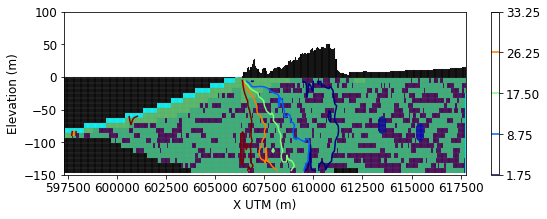

In [192]:
from matplotlib import cm

slicetype='Row'
slicenum= -1

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()
xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
# csa = xsect.plot_array(kj_lay_red,cmap='tab10')
csa = xsect.plot_array(np.log(hk),cmap='viridis')
# csa = xsect.plot_array(sconc,cmap='jet',vmin=0,vmax=35)

csa = xsect.contour_array(conc,cmap='jet',levels=35*np.array((.05,.25,.5,.75,.95)))

c = plt.colorbar(csa)
# wel = xsect.plot_bc("CHD")
wel = xsect.plot_ibound()
wel = xsect.plot_bc("GHB")

x = np.ravel([np.ones(20)*v for v in df_TDS.X_NAD83_UTM10N.values])
y = np.ravel([np.linspace(end,start,20) for end,start in zip(df_TDS.perf_end1_elev.values,df_TDS.perf_start1_elev.values)])
c = np.ravel([np.ones(20)*v for v in df_TDS.conc.values/1000])
plt.scatter(x,y,c=c,vmin=0,vmax=35,cmap='jet')




# t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-150,100))
plt.xlabel('X UTM (m)')
plt.show()
# c.set_label('log10(hk)')
# plt.savefig(figdir.joinpath('xsection_layers.png'),dpi=300,bbox_inches='tight')

In [154]:
import set_rc
set_rc.set_rc()

In [155]:
aem_rho_tmp = np.load(datadir.joinpath('AEM','resistivity','AEM_Modflowsize.npy'),allow_pickle=True)
aem_msk = aem_rho_tmp =='OUT'
aem_rho = np.zeros_like(aem_rho_tmp,dtype='float')
aem_rho[~aem_msk] = aem_rho_tmp[~aem_msk]
aem_rho[aem_msk] = np.nan
aem_rho=aem_rho.reshape((52,m_nm.nrow,m_nm.ncol))[::-1,::-1,:]
aem_rho = np.power(10,aem_rho)
ind_top_lay_0_lf = 20
ind_bot_lay_0_lf = 21
ind_bot_lay_19_lf = 40
aem_rho = aem_rho[ind_top_lay_0_lf:ind_bot_lay_19_lf,rows,:]   





findfont: Font family ['Corbel'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


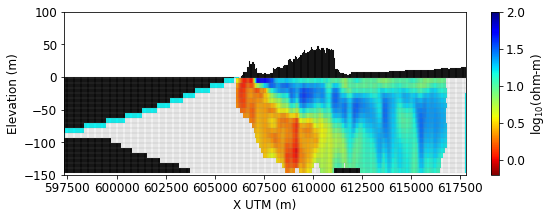

In [83]:
from matplotlib import cm

slicetype='Row'
slicenum= -1

# First step is to set up the plot
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 1, 1)

# Next we create an instance of the PlotCrossSection class
xsect = flopy.plot.PlotCrossSection(model=m, line={slicetype: slicenum},geographic_coords=True)
# xsect.plot_ibound()
xsect.plot_grid(linewidth=.1)
# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
# linecollection = xsect.plot_grid()
# patches = xsect.plot_ibound()
# csa = xsect.plot_array(layer_mapping_ind)
# cmap = cm.get_cmap('tab10', lay_m.shape[0])
csa = xsect.plot_array(np.log10(aem_rho),vmin=-.2,vmax=2,cmap='jet_r')
# csa = xsect.plot_array(kj_lay2,cmap='tab10')

c = plt.colorbar(csa)
c.set_label('log$_{10}$(ohm-m)')

# wel = xsect.plot_bc("CHD")
wel = xsect.plot_ibound()
wel = xsect.plot_bc("GHB")

# x = np.ravel([np.ones(20)*v for v in df_TDS.X_NAD83_UTM10N.values])
# y = np.ravel([np.linspace(end,start,20) for end,start in zip(df_TDS.perf_end1_elev.values,df_TDS.perf_start1_elev.values)])
# c = np.ravel([np.ones(20)*v for v in df_TDS.conc.values/1000])
# plt.scatter(x,y,c=c,vmin=0,vmax=35,cmap='jet')




# t = ax.set_title('{slicetype} {slicenum} Cross-Section'.format(slicetype=slicetype,slicenum=slicenum))
plt.ylabel('Elevation (m)')
plt.ylim((-150,100))
plt.xlabel('X UTM (m)')
plt.show()
# plt.savefig(figdir.joinpath('xsection_res.png'),dpi=300,bbox_inches='tight')

In [34]:
kj_layer_mapping = {}
kj_layer_mapping[1] = 'HydroStrat_Perched_A_Shallow'
kj_layer_mapping[2] = 'HydroStrat_Dune_Sand_Aquifer'
kj_layer_mapping[3] = 'HydroStrat_SVA'
kj_layer_mapping[4] = '180-Foot_Aquifer_Upper_180'
kj_layer_mapping[5] = '180-Foot_Aquifer_Intermediate_180_Aquitard'
kj_layer_mapping[6] = '180-Foot_Aquifer_Lower_180'
kj_layer_mapping[7] = 'HydroStrat_180_400_Ft_Aquitard'
kj_layer_mapping[8] = 'HydroStrat_400-Foot_Aquifer'

In [ ]:



if method=='simple':
    #Collect data from synthetic models
    d_tds = np.zeros((d_conc.shape[0],len(df_TDS)),dtype=np.float)
    for i,c in enumerate(d_conc):
        for j,loc in enumerate(df_TDS.inds_raveled.values):
            d_tds[i,j] = c[loc].mean()
elif method=='full':
    times_sim = ucnobj.get_times()
    times_real = float(starttime) + np.array(times_sim)/365
    loadtime_ind = []
    for i in range(len(df_TDS)):
        entry = df_TDS.date_rec.iloc[i]
        time_rec = entry.year  + entry.month/12
        loadtime_ind.append(np.argmin(np.abs(time_rec-times_real)))

    df_TDS = df_TDS.assign(loadtime_ind=loadtime_ind)

    d_tds = np.zeros((d_conc.shape[0],len(df_TDS)),dtype=np.float)
    for i,it in enumerate(its_AEM):
        if i%10==0:
            print(i)
        fname = [p for p in ucnpaths if p.split('/')[-1].startswith('conc{}'.format(it))][0]
        ucnobj = flopy.utils.binaryfile.UcnFile(fname)
        for tim_ind in df_TDS.loadtime_ind.unique():
            load_conc = ucnobj.get_data(totim=times[tim_ind])
            applytoinds = (tim_ind==df_TDS.loadtime_ind)[tim_ind==df_TDS.loadtime_ind].index.values
            for j in applytoinds:
                d_tds[i,j] = load_conc.flatten()[df_TDS.inds_raveled.values[j]].mean()


### Try making an int 180 aquitard

In [197]:
def make_surf(grid_old,m_old,m_new,method='nearest'):
    points = np.stack((m_old.modelgrid.xcellcenters.flatten(),m_old.modelgrid.ycellcenters.flatten())).T
    values = grid_old.flatten()
    grid_x=  m_new.modelgrid.xcellcenters
    grid_y=  m_new.modelgrid.ycellcenters
    return griddata(points, values, (grid_x, grid_y), method=method)



int180o = np.loadtxt(GISdir.joinpath("KJ_boundaries",'intermediate_180_older.csv'),skiprows=1,delimiter=',')
int180y = np.loadtxt(GISdir.joinpath("KJ_boundaries",'intermediate_180_younger.csv'),skiprows=1,delimiter=',')

In [198]:
points = int180o[:,:2]
values = int180o[:,2]
grid_x=  m_empty.modelgrid.xcellcenters
grid_y=  m_empty.modelgrid.ycellcenters
surfo = griddata(points, values, (grid_x, grid_y), method='nearest')

points = int180y[:,:2]
values = int180y[:,2]
surfy = griddata(points, values, (grid_x, grid_y), method='nearest')

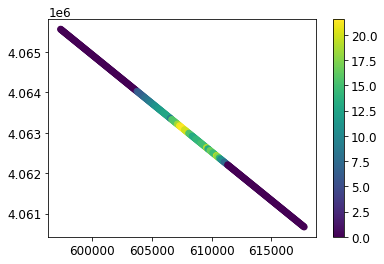

In [200]:
plt.scatter(grid_x,grid_y,c=surfy-surfo)
plt.colorbar()

In [27]:
import glob

# job_id = 3573022
# case='SV'

job_id = 3573239
case='NM'

## Find AEM data files
ouput_AEM = Path('/scratch/users/ianpg/SWIlarge/work/output/AEM/data/')
aempaths = glob.glob(ouput_AEM.joinpath('{case}*_{job_id}.npy'.format(case=case,job_id=job_id)).as_posix())
its_AEM = np.array([int(f.split('_')[-2]) for f in aempaths])

output_case = Path('/scratch/users/ianpg/SWIlarge/work/output/{}'.format(case))
f_varlist = Path('../data/PriorModel/varlist.pkl')
varlist = load_obj(f_varlist.parent,'varlist')

ucnpaths = glob.glob(output_case.joinpath('*_{job_id}.UCN'.format(job_id=job_id)).as_posix())
totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
its_tds = np.array([int(f.split('_')[0].split('/')[-1].lstrip('conc')) for f in ucnpaths])
success_AEM = np.array([True if it in its_AEM else False for it in its_tds])
failed = totims<14782
its_failed = its_tds[failed]
its_success = its_tds[~failed]

strange = [(it in its_failed) for it in its_AEM]
if np.any(strange):
    print('something weird here... failed seawat run ended up with AEM data?')
    
print('Case: {}\nNumber of SEAWAT runs: {} \nFailure rate: {} %'.format(case,len(failed),np.round(100*sum(failed)/len(failed),2)))


Case: NM
Number of SEAWAT runs: 498 
Failure rate: 0.8 %


In [28]:
print('loading...')
'''
d_conc and d_AEM stored by iteration number so there are some empty indices along first axis corresponding to its_failed
'''
# d_conc = np.zeros((500,20, 19, 345),dtype=np.float)
# d_conc_flat = np.zeros((500,20, 19, 345),dtype=np.float)


# d_AEM = np.zeros((500,2940),dtype=np.float) 
flag=0
for f,it_AEM in zip(aempaths,its_AEM):
    if flag==0:
        matshape_AEM = np.load(f).shape
        matsize_AEM= np.prod(matshape_AEM)
        d_AEM = np.zeros((max(its_tds+1),matsize_AEM),dtype=np.float) 
        flag=1
    d_AEM[it_AEM] = np.load(f,allow_pickle=True)


flag=0
for f,it_tds,it_inAEM in zip(ucnpaths,its_tds,success_AEM):        
    if it_inAEM:
        if flag==0:
            matshape_conc = np.load(f.rstrip('UCN') + 'npy').shape
            matsize_conc = np.prod(matshape_conc)
            d_conc = np.zeros((max(its_tds+1),matsize_conc))
            flag=1
        d_conc[it_tds] = np.load(f.rstrip('UCN') + 'npy').flatten()

        

#Verify that mats have missing rows in same indices
if np.all((np.where(~d_conc.any(axis=1))[0] ==  np.where(~d_AEM.any(axis=1))[0])):
    print('matrices line up!')
else:
    print('Warning: matrices do not line up!')        
        
        
keep_inds = np.where(d_conc.any(axis=1))[0]
d_AEM = -d_AEM[keep_inds,:]
d_conc = d_conc[keep_inds,:]

its_AEM = np.sort(its_AEM)
its_tds = np.sort(its_tds[success_AEM])

loading...
matrices line up!


##### Import TDS data